<a href="https://colab.research.google.com/github/Kr123456782255/r.k/blob/master/sales_data_set.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Assumptions : 
1. the unit price of a product 0 indicate that product is damaged or expired or thrown away
2. Negative qunatity is meaningless. I am assuming this as a manual error.
3. Customer whose Id is missing are considered as guests

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import io
import pickle
import datetime as dt
import seaborn as sns
sns.set()
from os import listdir
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

from sklearn.manifold import TSNE
from sklearn.preprocessing import LabelEncoder, StandardScaler, Normalizer
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn import preprocessing, model_selection, metrics, feature_selection

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
sales = pd.read_excel('sales_data.xlsx')

In [3]:
sales.isnull().sum()

transaction id                0
product id                    0
product description        1454
quantity sold                 0
transaction timestamp         0
unit price                    0
customer id              135080
transaction country           0
dtype: int64

In [4]:
sales.rename(columns = {'transaction id': 'Transaction_Id', 'product id':'Product_Id','product description':'Description',
                        'unit price':'Unit_Price','customer id':'Customer_Id','transaction country':'country',
                        'quantity sold':'quantity','transaction timestamp':'transaction_timestamp'},inplace = True)

In [5]:
sales.dropna(axis = 0, subset = ['Product_Id','Unit_Price','country'],inplace = True)

In [6]:
print('Dupplicate entries: {}'.format(sales.duplicated().sum()))
sales.drop_duplicates(inplace = True)

Dupplicate entries: 5268


In [7]:
sales.head()

,Transaction_Id,Product_Id,Description,quantity,transaction_timestamp,Unit_Price,Customer_Id,country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [8]:
sales.isnull().sum()/sales.shape[0]*100

Transaction_Id            0.000000
Product_Id                0.000000
Description               0.270945
quantity                  0.000000
transaction_timestamp     0.000000
Unit_Price                0.000000
Customer_Id              25.163377
country                   0.000000
dtype: float64

In [9]:
sales[sales.Description.isnull() == True].head()

,Transaction_Id,Product_Id,Description,quantity,transaction_timestamp,Unit_Price,Customer_Id,country
622,536414,22139,NaN,56,2010-12-01 11:52:00,0.0,NaN,United Kingdom
1970,536545,21134,NaN,1,2010-12-01 14:32:00,0.0,NaN,United Kingdom
1971,536546,22145,NaN,1,2010-12-01 14:33:00,0.0,NaN,United Kingdom
1972,536547,37509,NaN,1,2010-12-01 14:33:00,0.0,NaN,United Kingdom
1987,536549,85226A,NaN,1,2010-12-01 14:34:00,0.0,NaN,United Kingdom


It is clear from the table that products which doesnt have description have no customer Id, 0 unit price and irregular product id.
We are not able to draw any inference from it. so it is better to drow them

In [10]:
sales.dropna(axis = 0,subset = ['Description'],inplace = True)

In [11]:
sales.head()

,Transaction_Id,Product_Id,Description,quantity,transaction_timestamp,Unit_Price,Customer_Id,country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [12]:
sales.shape

(535187, 8)

In [13]:
sales.Transaction_Id.nunique()

24446

In [14]:
sales = sales[sales['Product_Id']!= 'POST']
sales = sales[sales['Product_Id']!= 'D']
sales = sales[sales['Product_Id']!= 'C2']
sales = sales[sales['Product_Id']!= 'M']
sales = sales[sales['Product_Id']!= 'BANK CHARGES']
sales = sales[sales['Product_Id']!= 'PADS']
sales = sales[sales['Product_Id']!= 'DOT']

the size of data frame is not changed. Meaning these product_id are dropped when we dropped rows with no description

In [15]:
sales.shape

(532399, 8)

In [16]:
sales.Transaction_Id = sales.Transaction_Id.astype(str)

In [17]:
sales["IsCancelled"]=np.where(sales.Transaction_Id.apply(lambda l: len(l)== 7), True, False)
sales.IsCancelled.value_counts() /sales.shape[0] * 100

False    98.351049
True      1.648951
Name: IsCancelled, dtype: float64

In [18]:
Damaged = sales[(sales.Customer_Id.isnull() == True) & (sales.Unit_Price == 0.0) ].copy()
Damaged.head()

,Transaction_Id,Product_Id,Description,quantity,transaction_timestamp,Unit_Price,Customer_Id,country,IsCancelled
6391,536941,22734,amazon,20,2010-12-03 12:08:00,0.0,NaN,United Kingdom,False
6392,536942,22139,amazon,15,2010-12-03 12:08:00,0.0,NaN,United Kingdom,False
7313,537032,21275,?,-30,2010-12-03 16:50:00,0.0,NaN,United Kingdom,False
13217,537425,84968F,check,-20,2010-12-06 15:35:00,0.0,NaN,United Kingdom,False
13218,537426,84968E,check,-35,2010-12-06 15:36:00,0.0,NaN,United Kingdom,False


In [19]:
Damaged.shape

(1014, 9)

In [20]:
Damaged.describe()

,quantity,Unit_Price,Customer_Id
count,1014.000000,1014.0,0.0
mean,-132.778107,0.0,NaN
std,687.927232,0.0,NaN
min,-9600.000000,0.0,NaN
25%,-62.000000,0.0,NaN
50%,1.000000,0.0,NaN
75%,2.000000,0.0,NaN
max,4000.000000,0.0,NaN


In [21]:
sales.Product_Id.nunique()

3951

** Assumed Damaged products does not have a customer and Unit price is 0 **

In [22]:
Clean_sales = sales[~((sales.Customer_Id.isnull() == True) & (sales.Unit_Price == 0))]

In [23]:
Clean_sales.head()

,Transaction_Id,Product_Id,Description,quantity,transaction_timestamp,Unit_Price,Customer_Id,country,IsCancelled
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,False
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,False
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,False
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,False
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,False


In [24]:
Clean_sales.shape

(531385, 9)

In [25]:
Promotions = Clean_sales[(Clean_sales.IsCancelled == False) & (Clean_sales.quantity < 0) | (Clean_sales.Unit_Price == 0)].copy()

In [26]:
Promotions.shape

(33, 9)

In [27]:
Cancelled_orders = Clean_sales[(Clean_sales['IsCancelled'] == True) & (Clean_sales.Unit_Price != 0)].copy()

In [28]:
Cancelled_orders.describe()

,quantity,Unit_Price,Customer_Id
count,8779.000000,8779.000000,8522.000000
mean,-30.769108,31.157800,14993.272237
std,1178.300769,555.734865,1704.727976
min,-80995.000000,-11062.060000,12346.000000
25%,-6.000000,1.450000,13524.000000
50%,-2.000000,2.750000,14895.000000
75%,-1.000000,4.950000,16393.000000
max,1.000000,17836.460000,18282.000000


In [29]:
Cancelled_orders.shape

(8779, 9)

In [30]:
Clean_sales = Clean_sales[Clean_sales['IsCancelled'] == False].copy()

In [31]:
Clean_sales.shape

(522606, 9)

In [32]:
Clean_sales.Product_Id.nunique()

3915

In [33]:
Clean_sales.Customer_Id.nunique()

4335

In [34]:
Clean_sales = Clean_sales[(Clean_sales['IsCancelled'] == False) & (Clean_sales['quantity'] > 0) & (Clean_sales.Unit_Price >0)].copy()

In [35]:
Clean_sales.describe()

,quantity,Unit_Price,Customer_Id
count,522573.000000,522573.000000,391150.000000
mean,10.642383,3.301495,15295.171456
std,156.589197,19.239075,1710.339033
min,1.000000,0.040000,12346.000000
25%,1.000000,1.250000,13969.000000
50%,4.000000,2.080000,15159.000000
75%,12.000000,4.130000,16794.000000
max,80995.000000,13541.330000,18287.000000


In [36]:
Clean_sales.shape

(522573, 9)

In [37]:
Guest_sales = Clean_sales[Clean_sales.Customer_Id.isnull() == True].copy()

In [38]:
sales['Product_Id'].nunique()

3951

In [39]:
Clean_sales['Product_Id'].nunique()

3915

In [40]:
Clean_sales = Clean_sales[Clean_sales.Customer_Id.isnull() == False].copy()

In [41]:
Clean_sales['Product_Id'].nunique()

3659

In [42]:
Clean_sales['Revenue'] = Clean_sales['quantity']*Clean_sales['Unit_Price']

In [43]:
Guest_sales['Revenue'] = Guest_sales['quantity']*Guest_sales['Unit_Price']

In [44]:
Clean_sales['Revenue'].sum()/Guest_sales['Revenue'].sum()

5.7311929705565

In [45]:
Clean_sales.describe()

,quantity,Unit_Price,Customer_Id,Revenue
count,391150.000000,391150.000000,391150.000000,391150.000000
mean,13.145300,2.874372,15295.171456,22.337281
std,180.807831,4.284738,1710.339033,310.932442
min,1.000000,0.040000,12346.000000,0.060000
25%,2.000000,1.250000,13969.000000,4.950000
50%,6.000000,1.950000,15159.000000,11.900000
75%,12.000000,3.750000,16794.000000,19.800000
max,80995.000000,649.500000,18287.000000,168469.600000


In [46]:
Guest_sales.describe()

,quantity,Unit_Price,Customer_Id,Revenue
count,131423.000000,131423.000000,0.0,131423.000000
mean,3.193033,4.572727,NaN,11.599980
std,11.231307,37.616373,NaN,57.285455
min,1.000000,0.060000,NaN,0.060000
25%,1.000000,1.630000,NaN,2.500000
50%,1.000000,3.290000,NaN,4.960000
75%,3.000000,5.400000,NaN,10.790000
max,1820.000000,13541.330000,NaN,13541.330000


In [47]:
T_Customers = Clean_sales.Customer_Id.nunique()

In [48]:
Clean_sales.groupby('Customer_Id').Product_Id.nunique().value_counts()/T_Customers

1      0.021689
10     0.019843
8      0.018228
9      0.018228
11     0.017997
         ...   
305    0.000231
301    0.000231
285    0.000231
281    0.000231
699    0.000231
Name: Product_Id, Length: 339, dtype: float64

Most people only brought 1 or 2 products.

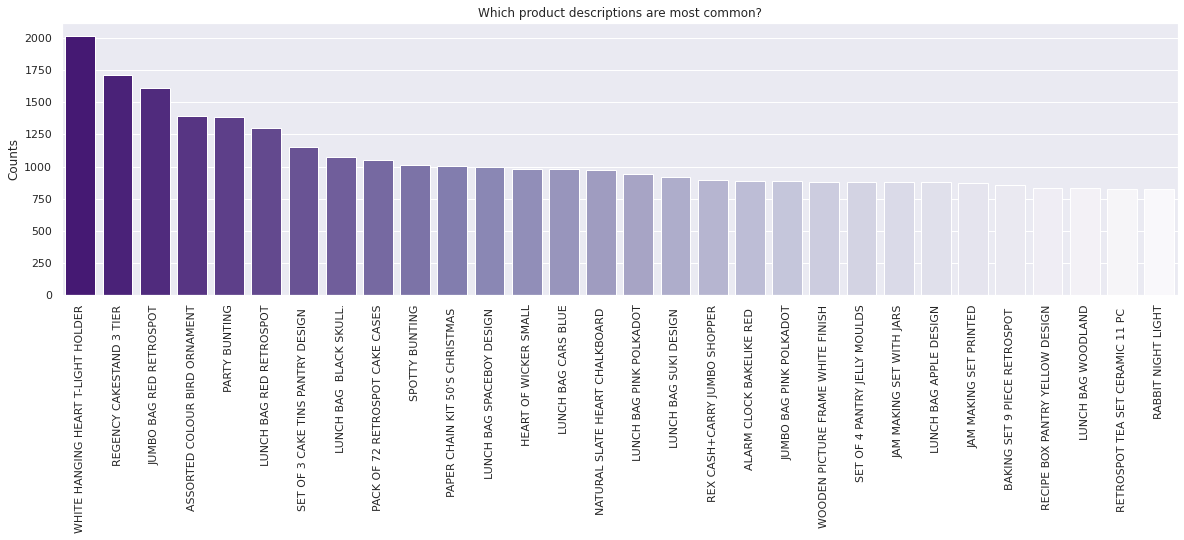

In [49]:
description_counts = Clean_sales.Description.value_counts().sort_values(ascending=False).iloc[0:30]
plt.figure(figsize=(20,5))
sns.barplot(description_counts.index, description_counts.values, palette="Purples_r")
plt.ylabel("Counts")
plt.title("Which product descriptions are most common?");
plt.xticks(rotation=90);

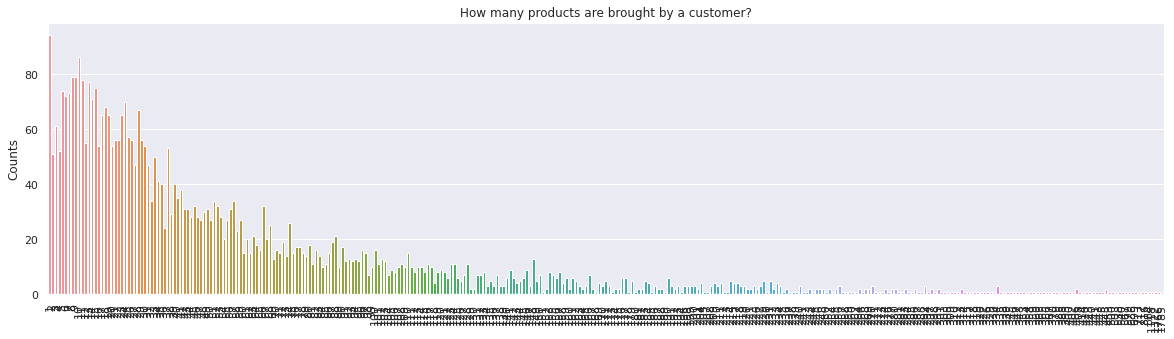

In [50]:
Product_Per_person_count = Clean_sales.groupby('Customer_Id').Product_Id.nunique().value_counts()
plt.figure(figsize=(20,5))
sns.barplot(Product_Per_person_count.index, Product_Per_person_count.values)
plt.ylabel("Counts")
plt.title("How many products are brought by a customer?");
plt.xticks(rotation=90);

# It is clear that most people brought only 1 or 2 products.

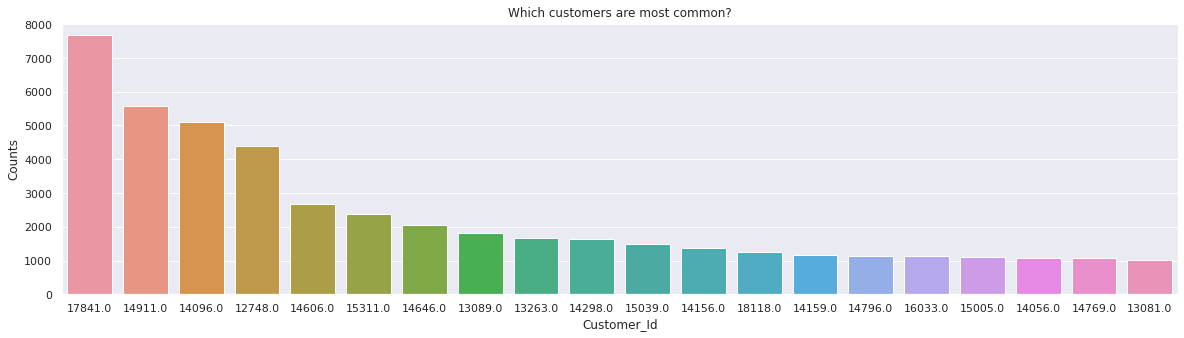

In [51]:
customer_counts = Clean_sales.Customer_Id.value_counts().sort_values(ascending=False).iloc[0:20] 
plt.figure(figsize=(20,5))
sns.barplot(customer_counts.index, customer_counts.values, order=customer_counts.index)
plt.ylabel("Counts")
plt.xlabel("Customer_Id")
plt.title("Which customers are most common?");

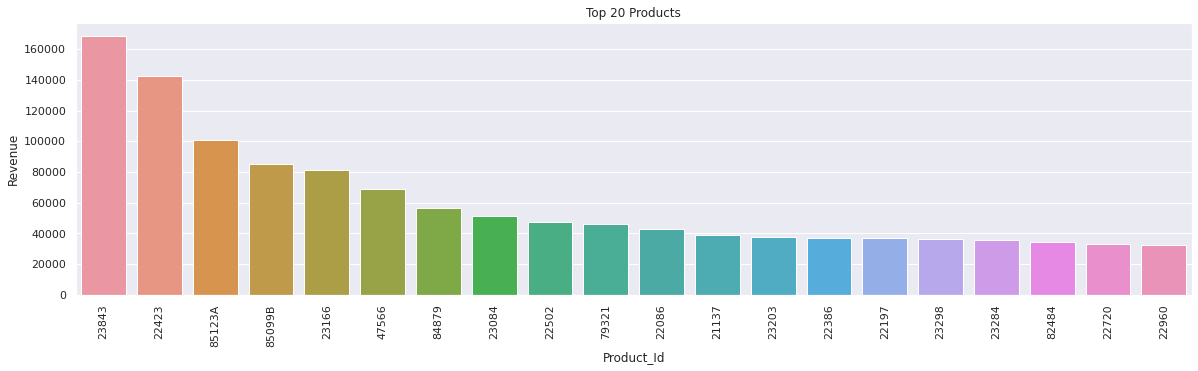

In [52]:
Revenue_Product = Clean_sales.groupby('Product_Id').Revenue.sum()
Revenue_Product = Revenue_Product.sort_values(ascending = False).iloc[0:20]
plt.figure(figsize=(20,5))
sns.barplot(Revenue_Product.index,Revenue_Product.values,order = Revenue_Product.index)
plt.ylabel("Revenue")
plt.title("Top 20 Products");
plt.xticks(rotation=90);

In [53]:
Clean_sales.country.nunique()

37

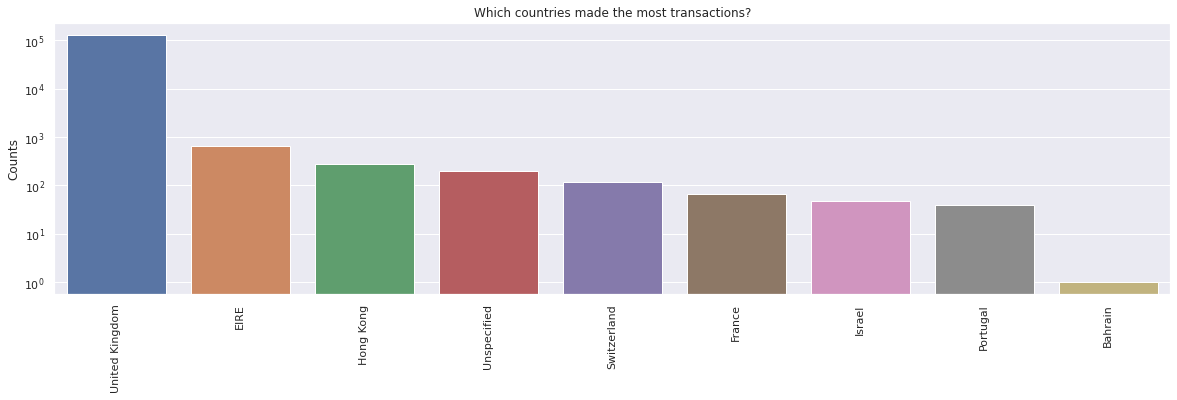

In [54]:
country_counts = Guest_sales.country.value_counts().sort_values(ascending=False).iloc[0:20]
plt.figure(figsize=(20,5))
sns.barplot(country_counts.index, country_counts.values)
plt.ylabel("Counts")
plt.title("Which countries made the most transactions?");
plt.xticks(rotation=90);
plt.yscale("log")

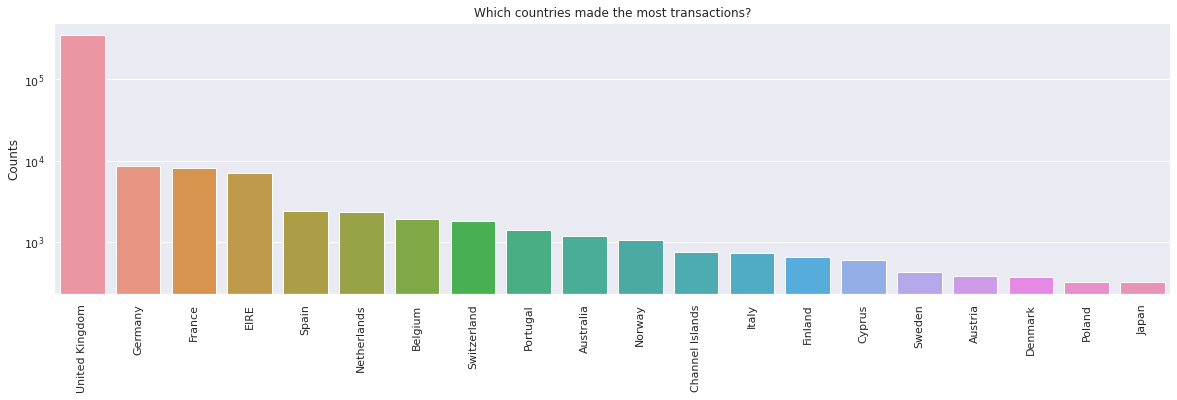

In [55]:
country_counts = Clean_sales.country.value_counts().sort_values(ascending=False).iloc[0:20]
plt.figure(figsize=(20,5))
sns.barplot(country_counts.index, country_counts.values)
plt.ylabel("Counts")
plt.title("Which countries made the most transactions?");
plt.xticks(rotation=90);
plt.yscale("log")

In [56]:
Clean_sales.loc[Clean_sales.country=="United Kingdom"].shape[0] / Clean_sales.shape[0] * 100

89.19135881375432

In [57]:
Clean_sales.Unit_Price.describe()

count    391150.000000
mean          2.874372
std           4.284738
min           0.040000
25%           1.250000
50%           1.950000
75%           3.750000
max         649.500000
Name: Unit_Price, dtype: float64

In [58]:
upper_quantity = np.quantile(Guest_sales.quantity,0.95)

In [59]:
upper_price = np.quantile(Guest_sales.Unit_Price,0.95)

In [60]:
Guest_sales = Guest_sales[(Guest_sales.Unit_Price < upper_price) & (Guest_sales.quantity < upper_quantity)].copy()

In [61]:
Clean_sales.describe()

,quantity,Unit_Price,Customer_Id,Revenue
count,391150.000000,391150.000000,391150.000000,391150.000000
mean,13.145300,2.874372,15295.171456,22.337281
std,180.807831,4.284738,1710.339033,310.932442
min,1.000000,0.040000,12346.000000,0.060000
25%,2.000000,1.250000,13969.000000,4.950000
50%,6.000000,1.950000,15159.000000,11.900000
75%,12.000000,3.750000,16794.000000,19.800000
max,80995.000000,649.500000,18287.000000,168469.600000


In [62]:
Guest_sales.describe()

,quantity,Unit_Price,Customer_Id,Revenue
count,117859.000000,117859.000000,0.0,117859.000000
mean,1.995138,3.756508,NaN,6.908579
std,1.643120,2.717500,NaN,7.811259
min,1.000000,0.060000,NaN,0.060000
25%,1.000000,1.630000,NaN,2.460000
50%,1.000000,3.290000,NaN,4.210000
75%,2.000000,4.960000,NaN,8.290000
max,9.000000,13.130000,NaN,116.550000


In [63]:
Clean_sales['Revenue'].sum()/Guest_sales['Revenue'].sum()

10.730554817988152

In [64]:
Guest_sales.Transaction_Id.nunique()

1331

In [65]:
Guest_sales['Revenue'].sum()/(Clean_sales['Revenue'].sum()+Guest_sales['Revenue'].sum())

0.08524745977628917

In [66]:
Clean_sales['Revenue'].sum()/(Clean_sales['Revenue'].sum()+Guest_sales['Revenue'].sum())

0.9147525402237109

In [67]:
16174/(16174+19309)*100

45.58239156779303

In [68]:
Clean_sales.Transaction_Id.nunique()

18402

In [69]:
Clean_sales.quantity.describe()

count    391150.000000
mean         13.145300
std         180.807831
min           1.000000
25%           2.000000
50%           6.000000
75%          12.000000
max       80995.000000
Name: quantity, dtype: float64

In [70]:
Clean_sales["Year"] = Clean_sales.transaction_timestamp.dt.year
Clean_sales["Quarter"] = Clean_sales.transaction_timestamp.dt.quarter
Clean_sales["Month"] = Clean_sales.transaction_timestamp.dt.month
Clean_sales["Week"] = Clean_sales.transaction_timestamp.dt.week
Clean_sales["Weekday"] = Clean_sales.transaction_timestamp.dt.weekday
Clean_sales["Day"] = Clean_sales.transaction_timestamp.dt.day
Clean_sales["Dayofyear"] = Clean_sales.transaction_timestamp.dt.dayofyear
Clean_sales["Date"] = pd.to_datetime(Clean_sales[['Year', 'Month', 'Day']])

In [71]:
grouped_features = ["Date", "Year", "Quarter","Month", "Week", "Weekday", "Dayofyear", "Day",
                    "Product_Id"]

In [72]:
daily_data = pd.DataFrame(Clean_sales.groupby(grouped_features).quantity.sum(),columns=["quantity"])
daily_data["Revenue"] = Clean_sales.groupby(grouped_features).Revenue.sum()
daily_data = daily_data.reset_index()
daily_data.shape

(221811, 11)

In [73]:
daily_data.loc[:, ["quantity", "Revenue"]].describe()

,quantity,Revenue
count,221811.000000,221811.000000
mean,23.180924,39.390416
std,241.777282,417.366449
min,1.000000,0.060000
25%,3.000000,6.750000
50%,9.000000,15.600000
75%,24.000000,33.750000
max,80995.000000,168469.600000


In [74]:
Cancelled_orders.Transaction_Id.nunique()

3490

In [75]:
low_quantity = daily_data.quantity.quantile(0.01)
high_quantity = daily_data.quantity.quantile(0.99)
print((low_quantity, high_quantity))

(1.0, 225.0)


In [76]:
low_revenue = daily_data.Revenue.quantile(0.01)
high_revenue = daily_data.Revenue.quantile(0.99)
print((low_revenue, high_revenue))

(0.65, 373.49899999999934)


In [77]:
daily_data = daily_data.loc[
    (daily_data.quantity >= low_quantity) & (daily_data.quantity <= high_quantity)]
daily_data = daily_data.loc[
    (daily_data.Revenue >= low_revenue) & (daily_data.Revenue <= high_revenue)]

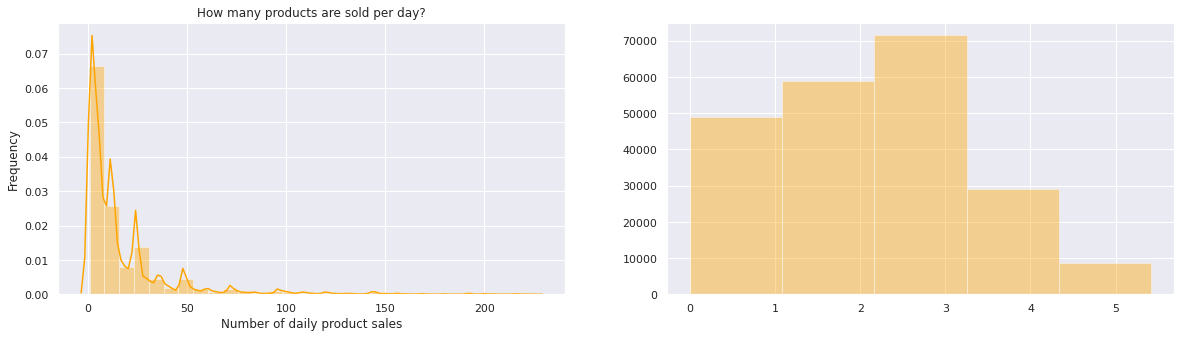

In [78]:
fig, ax = plt.subplots(1,2,figsize=(20,5))
sns.distplot(daily_data.quantity.values, kde=True, ax=ax[0], color="Orange", bins=30);
sns.distplot(np.log(daily_data.quantity.values), kde=False, ax=ax[1], color="Orange", bins=5);
ax[0].set_xlabel("Number of daily product sales");
ax[0].set_ylabel("Frequency");
ax[0].set_title("How many products are sold per day?");

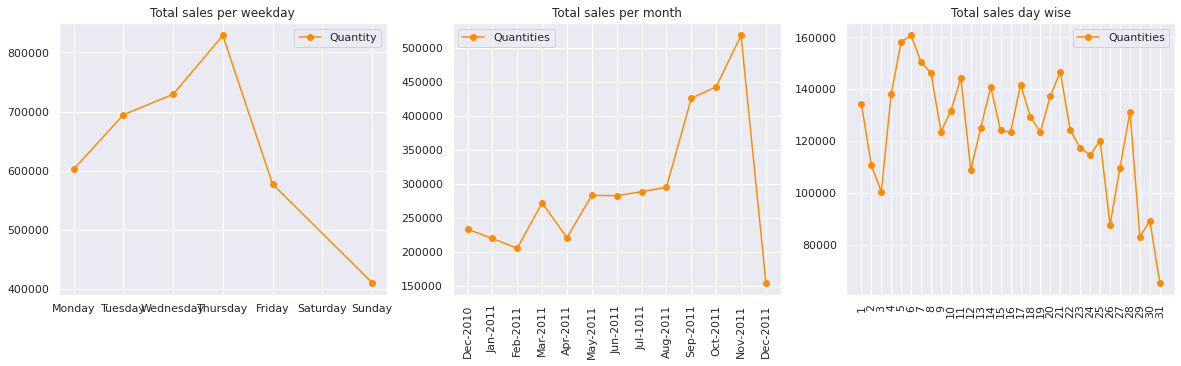

In [79]:
fig, ax = plt.subplots(1,3,figsize=(20,5))

weekdays = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
yearmonth = ["Dec-2010", "Jan-2011", "Feb-2011", "Mar-2011", "Apr-2011", "May-2011",
             "Jun-2011", "Jul-1011", "Aug-2011", "Sep-2011", "Oct-2011", "Nov-2011", 
             "Dec-2011"]
Day_of_Month = [i+1 for i in range(31)]
daily_data.groupby("Weekday").quantity.sum().plot(
    ax=ax[0], marker='o', label="Quantity", c="darkorange");
ax[0].legend();
ax[0].set_xticks(np.arange(0,7))
ax[0].set_xticklabels(weekdays);
ax[0].set_xlabel("")
ax[0].set_title("Total sales per weekday");

ax[1].plot(daily_data.groupby(["Year", "Month"]).quantity.sum().values,
    marker='o', label="Quantities", c="darkorange");
ax[1].set_xticklabels(yearmonth, rotation=90)
ax[1].set_xticks(np.arange(0, len(yearmonth)))
ax[1].legend();
ax[1].set_title("Total sales per month");

ax[2].plot(daily_data.groupby(["Day"]).quantity.sum().values,
    marker='o', label="Quantities", c="darkorange");
ax[2].set_xticklabels(Day_of_Month, rotation=90)
ax[2].set_xticks(np.arange(0, len(Day_of_Month)))
ax[2].legend();
ax[2].set_title("Total sales day wise");

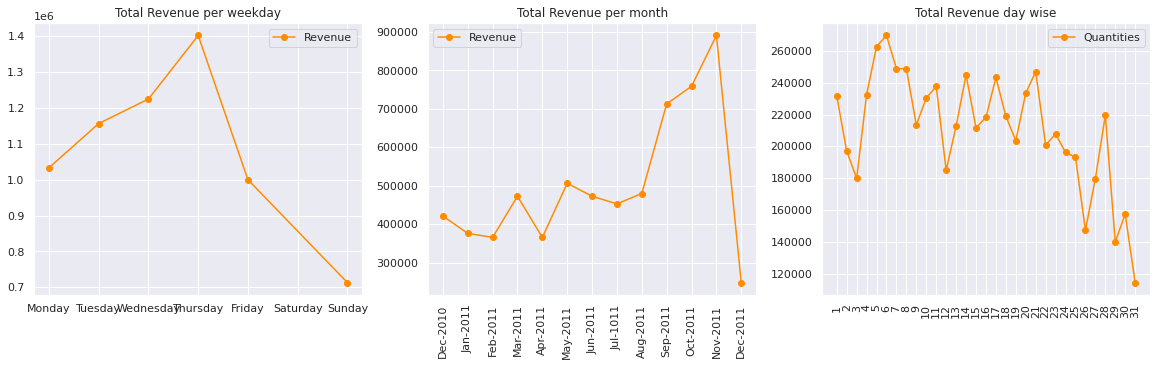

In [80]:
fig, ax = plt.subplots(1,3,figsize=(20,5))

weekdays = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
yearmonth = ["Dec-2010", "Jan-2011", "Feb-2011", "Mar-2011", "Apr-2011", "May-2011",
             "Jun-2011", "Jul-1011", "Aug-2011", "Sep-2011", "Oct-2011", "Nov-2011", 
             "Dec-2011"]

daily_data.groupby("Weekday").Revenue.sum().plot(
    ax=ax[0], marker='o', label="Revenue", c="darkorange");
ax[0].legend();
ax[0].set_xticks(np.arange(0,7))
ax[0].set_xticklabels(weekdays);
ax[0].set_xlabel("")
ax[0].set_title("Total Revenue per weekday");

ax[1].plot(daily_data.groupby(["Year", "Month"]).Revenue.sum().values,
    marker='o', label="Revenue", c="darkorange");
ax[1].set_xticklabels(yearmonth, rotation=90)
ax[1].set_xticks(np.arange(0, len(yearmonth)))
ax[1].legend();
ax[1].set_title("Total Revenue per month");

ax[2].plot(daily_data.groupby(["Day"]).Revenue.sum().values,
    marker='o', label="Quantities", c="darkorange");
ax[2].set_xticklabels(Day_of_Month, rotation=90)
ax[2].set_xticks(np.arange(0, len(Day_of_Month)))
ax[2].legend();
ax[2].set_title("Total Revenue day wise");

In [81]:
Clean_sales['Revenue'].sum()/Guest_sales['Revenue'].sum()

10.730554817988152

In [82]:
Guest_sales["Year"] = Guest_sales.transaction_timestamp.dt.year
Guest_sales["Quarter"] = Guest_sales.transaction_timestamp.dt.quarter
Guest_sales["Month"] = Guest_sales.transaction_timestamp.dt.month
Guest_sales["Week"] = Guest_sales.transaction_timestamp.dt.week
Guest_sales["Weekday"] = Guest_sales.transaction_timestamp.dt.weekday
Guest_sales["Day"] = Guest_sales.transaction_timestamp.dt.day
Guest_sales["Dayofyear"] = Guest_sales.transaction_timestamp.dt.dayofyear
Guest_sales["Date"] = pd.to_datetime(Guest_sales[['Year', 'Month', 'Day']])
Guest_sales.shape

(117859, 18)

In [83]:
daily_data_guest = pd.DataFrame(Guest_sales.groupby(grouped_features).quantity.sum(),columns=["quantity"])
daily_data_guest["Revenue"] = Guest_sales.groupby(grouped_features).Revenue.sum()
daily_data_guest= daily_data.reset_index()
daily_data_guest.shape

(216695, 12)

In [84]:
daily_data_guest.loc[:, ["quantity", "Revenue"]].describe()

,quantity,Revenue
count,216695.000000,216695.000000
mean,17.732190,30.120092
std,26.766261,44.129929
min,1.000000,0.650000
25%,3.000000,6.800000
50%,9.000000,15.400000
75%,24.000000,32.370000
max,225.000000,373.400000


In [85]:
low_quantity = daily_data_guest.quantity.quantile(0.01)
high_quantity = daily_data_guest.quantity.quantile(0.99)
print((low_quantity, high_quantity))

(1.0, 144.0)


In [86]:
Clean_sales.Product_Id.nunique()

3659

In [87]:
Guest_sales.Product_Id.nunique()

3257

In [88]:
Cancelled_orders.Product_Id.nunique()

1942

In [89]:
Damaged.Product_Id.nunique()

620

In [90]:
low_revenue = daily_data_guest.Revenue.quantile(0.01)
high_revenue = daily_data_guest.Revenue.quantile(0.99)
print((low_revenue, high_revenue))

(0.85, 238.50899999999965)


In [91]:
daily_data_guest = daily_data_guest.loc[
    (daily_data_guest.quantity >= low_quantity) & (daily_data_guest.quantity <= high_quantity)]
daily_data_guest = daily_data_guest.loc[
    (daily_data_guest.Revenue >= low_revenue) & (daily_data_guest.Revenue <= high_revenue)]

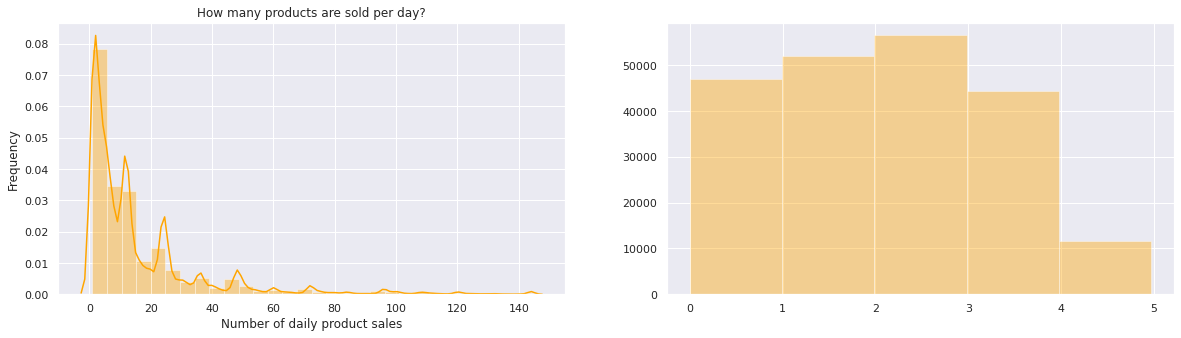

In [92]:
fig, ax = plt.subplots(1,2,figsize=(20,5))
sns.distplot(daily_data_guest.quantity.values, kde=True, ax=ax[0], color="Orange", bins=30);
sns.distplot(np.log(daily_data_guest.quantity.values), kde=False, ax=ax[1], color="Orange", bins=5);
ax[0].set_xlabel("Number of daily product sales");
ax[0].set_ylabel("Frequency");
ax[0].set_title("How many products are sold per day?");

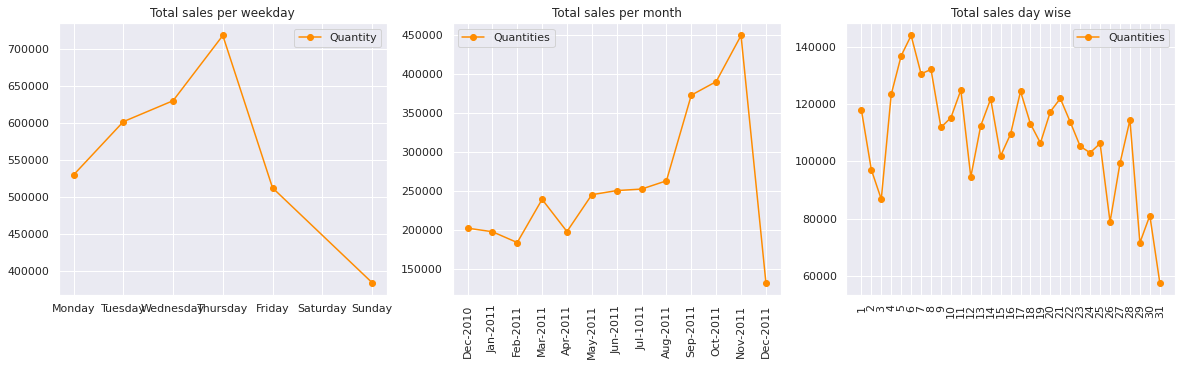

In [93]:

fig, ax = plt.subplots(1,3,figsize=(20,5))

weekdays = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
yearmonth = ["Dec-2010", "Jan-2011", "Feb-2011", "Mar-2011", "Apr-2011", "May-2011",
             "Jun-2011", "Jul-1011", "Aug-2011", "Sep-2011", "Oct-2011", "Nov-2011", 
             "Dec-2011"]
Day_of_Month = [i+1 for i in range(31)]
daily_data_guest.groupby("Weekday").quantity.sum().plot(
    ax=ax[0], marker='o', label="Quantity", c="darkorange");
ax[0].legend();
ax[0].set_xticks(np.arange(0,7))
ax[0].set_xticklabels(weekdays);
ax[0].set_xlabel("")
ax[0].set_title("Total sales per weekday");

ax[1].plot(daily_data_guest.groupby(["Year", "Month"]).quantity.sum().values,
    marker='o', label="Quantities", c="darkorange");
ax[1].set_xticklabels(yearmonth, rotation=90)
ax[1].set_xticks(np.arange(0, len(yearmonth)))
ax[1].legend();
ax[1].set_title("Total sales per month");

ax[2].plot(daily_data_guest.groupby(["Day"]).quantity.sum().values,
    marker='o', label="Quantities", c="darkorange");
ax[2].set_xticklabels(Day_of_Month, rotation=90)
ax[2].set_xticks(np.arange(0, len(Day_of_Month)))
ax[2].legend();
ax[2].set_title("Total sales day wise");

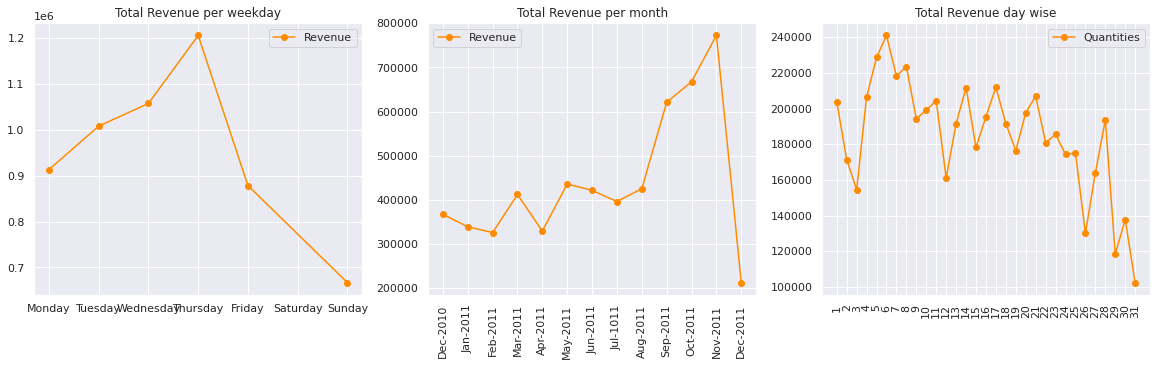

In [94]:
fig, ax = plt.subplots(1,3,figsize=(20,5))

weekdays = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
yearmonth = ["Dec-2010", "Jan-2011", "Feb-2011", "Mar-2011", "Apr-2011", "May-2011",
             "Jun-2011", "Jul-1011", "Aug-2011", "Sep-2011", "Oct-2011", "Nov-2011", 
             "Dec-2011"]

daily_data_guest.groupby("Weekday").Revenue.sum().plot(
    ax=ax[0], marker='o', label="Revenue", c="darkorange");
ax[0].legend();
ax[0].set_xticks(np.arange(0,7))
ax[0].set_xticklabels(weekdays);
ax[0].set_xlabel("")
ax[0].set_title("Total Revenue per weekday");

ax[1].plot(daily_data_guest.groupby(["Year", "Month"]).Revenue.sum().values,
    marker='o', label="Revenue", c="darkorange");
ax[1].set_xticklabels(yearmonth, rotation=90)
ax[1].set_xticks(np.arange(0, len(yearmonth)))
ax[1].legend();
ax[1].set_title("Total Revenue per month");

ax[2].plot(daily_data_guest.groupby(["Day"]).Revenue.sum().values,
    marker='o', label="Quantities", c="darkorange");
ax[2].set_xticklabels(Day_of_Month, rotation=90)
ax[2].set_xticks(np.arange(0, len(Day_of_Month)))
ax[2].legend();
ax[2].set_title("Total Revenue day wise");

In [95]:
Clean_sales.groupby(["Year","Month",'Customer_Id']).Customer_Id.nunique()

Year  Month  Customer_Id
2010  12     12347.0        1
             12348.0        1
             12370.0        1
             12377.0        1
             12383.0        1
                           ..
2011  12     18245.0        1
             18272.0        1
             18273.0        1
             18282.0        1
             18283.0        1
Name: Customer_Id, Length: 13023, dtype: int64

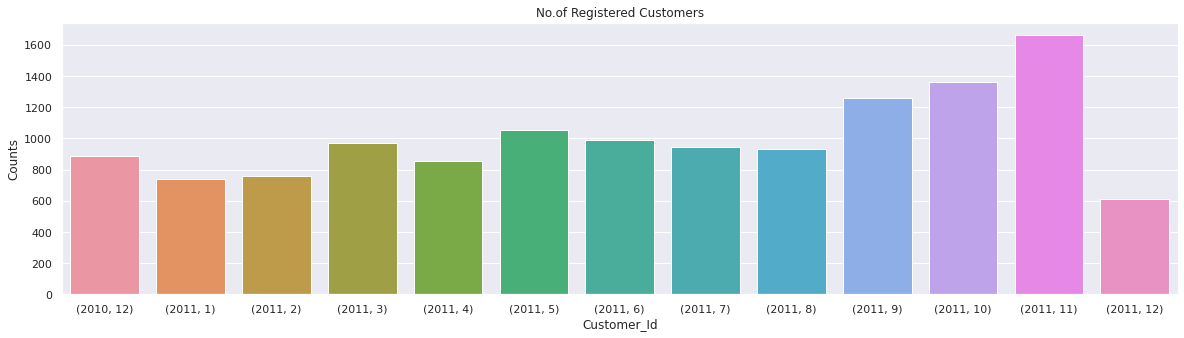

In [96]:
Customer_counts = Clean_sales.groupby(["Year","Month",'Customer_Id']).Customer_Id.nunique().groupby(['Year','Month']).sum()
plt.figure(figsize=(20,5))
sns.barplot(Customer_counts.index, Customer_counts.values, order=Customer_counts.index)
plt.ylabel("Counts")
plt.xlabel("Customer_Id")
plt.title("No.of Registered Customers");

In [97]:
Guest_sales.head()

,Transaction_Id,Product_Id,Description,quantity,transaction_timestamp,Unit_Price,Customer_Id,country,IsCancelled,Revenue,Year,Quarter,Month,Week,Weekday,Day,Dayofyear,Date
1443,536544,21773,DECORATIVE ROSE BATHROOM BOTTLE,1,2010-12-01 14:32:00,2.51,NaN,United Kingdom,False,2.51,2010,4,12,48,2,1,335,2010-12-01
1444,536544,21774,DECORATIVE CATS BATHROOM BOTTLE,2,2010-12-01 14:32:00,2.51,NaN,United Kingdom,False,5.02,2010,4,12,48,2,1,335,2010-12-01
1445,536544,21786,POLKADOT RAIN HAT,4,2010-12-01 14:32:00,0.85,NaN,United Kingdom,False,3.40,2010,4,12,48,2,1,335,2010-12-01
1446,536544,21787,RAIN PONCHO RETROSPOT,2,2010-12-01 14:32:00,1.66,NaN,United Kingdom,False,3.32,2010,4,12,48,2,1,335,2010-12-01
1447,536544,21790,VINTAGE SNAP CARDS,9,2010-12-01 14:32:00,1.66,NaN,United Kingdom,False,14.94,2010,4,12,48,2,1,335,2010-12-01


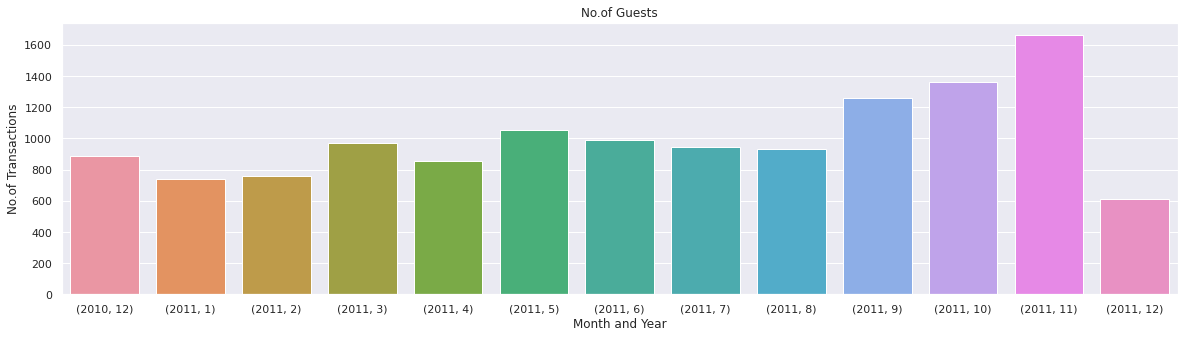

In [98]:
Customer_Counts = Guest_sales.groupby(["Year","Month",'Transaction_Id']).Transaction_Id.nunique().groupby(['Year','Month']).sum()
plt.figure(figsize=(20,5))
sns.barplot(Customer_counts.index, Customer_counts.values, order=Customer_counts.index)
plt.ylabel("No.of Transactions")
plt.xlabel("Month and Year")
plt.title("No.of Guests");

No.of Guests and No.of Customers are same

In [99]:
Cancelled_orders.head()

,Transaction_Id,Product_Id,Description,quantity,transaction_timestamp,Unit_Price,Customer_Id,country,IsCancelled
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,2010-12-01 09:49:00,4.65,15311.0,United Kingdom,True
235,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,2010-12-01 10:24:00,1.65,17548.0,United Kingdom,True
236,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548.0,United Kingdom,True
237,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548.0,United Kingdom,True
238,C536391,21980,PACK OF 12 RED RETROSPOT TISSUES,-24,2010-12-01 10:24:00,0.29,17548.0,United Kingdom,True


In [100]:
Cancelled_orders.describe()

,quantity,Unit_Price,Customer_Id
count,8779.000000,8779.000000,8522.000000
mean,-30.769108,31.157800,14993.272237
std,1178.300769,555.734865,1704.727976
min,-80995.000000,-11062.060000,12346.000000
25%,-6.000000,1.450000,13524.000000
50%,-2.000000,2.750000,14895.000000
75%,-1.000000,4.950000,16393.000000
max,1.000000,17836.460000,18282.000000


In [101]:
Cancelled_orders = Cancelled_orders.loc[Cancelled_orders.quantity < 80].copy()

In [102]:
high_quantity = Cancelled_orders.quantity.quantile(0.99)
print(high_quantity)
high_price = Cancelled_orders.Unit_Price.quantile(0.99)
print(high_price)
Cancelled_orders = Cancelled_orders.loc[Cancelled_orders.quantity <= high_quantity]
Cancelled_orders = Cancelled_orders.loc[Cancelled_orders.Unit_Price <= high_price]

-1.0
52.05279999999984


In [103]:
Cancelled_orders.describe()

,quantity,Unit_Price,Customer_Id
count,8689.000000,8689.000000,8483.000000
mean,-31.077800,4.082660,14991.688671
std,1184.384196,4.401146,1706.092061
min,-80995.000000,0.030000,12346.000000
25%,-6.000000,1.450000,13517.000000
50%,-2.000000,2.550000,14895.000000
75%,-1.000000,4.950000,16393.000000
max,-1.000000,52.000000,18282.000000


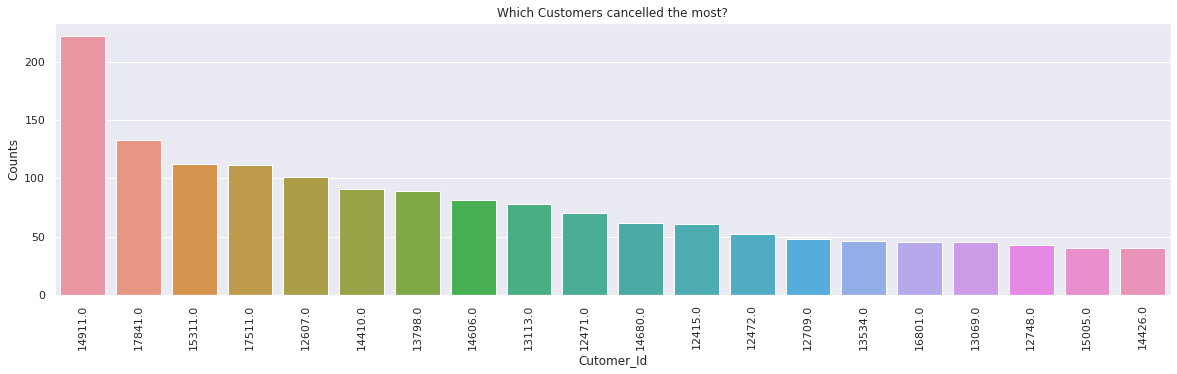

In [104]:
Cancelled_Ids = Cancelled_orders.Customer_Id.value_counts().sort_values(ascending=False).iloc[0:20]
plt.figure(figsize=(20,5))
sns.barplot(Cancelled_Ids.index, Cancelled_Ids.values,order = Cancelled_Ids.index)
plt.ylabel("Counts")
plt.xlabel('Cutomer_Id')
plt.title("Which Customers cancelled the most?");
plt.xticks(rotation=90);

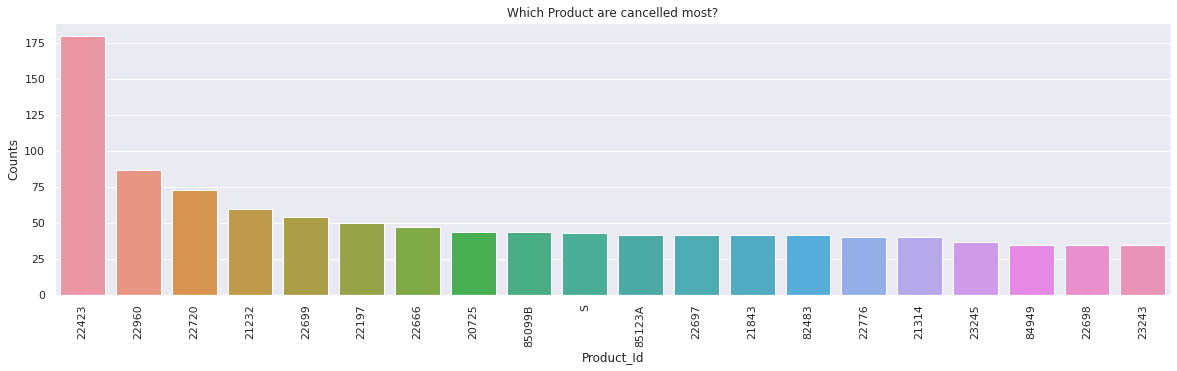

In [105]:
Cancelled_Ids = Cancelled_orders.Product_Id.value_counts().sort_values(ascending=False).iloc[0:20]
plt.figure(figsize=(20,5))
sns.barplot(Cancelled_Ids.index, Cancelled_Ids.values,order = Cancelled_Ids.index)
plt.ylabel("Counts")
plt.xlabel('Product_Id')
plt.title("Which Product are cancelled most?");
plt.xticks(rotation=90);

In [106]:
Cancelled_Ids = Cancelled_orders.Product_Id.value_counts().sort_values(ascending=False)

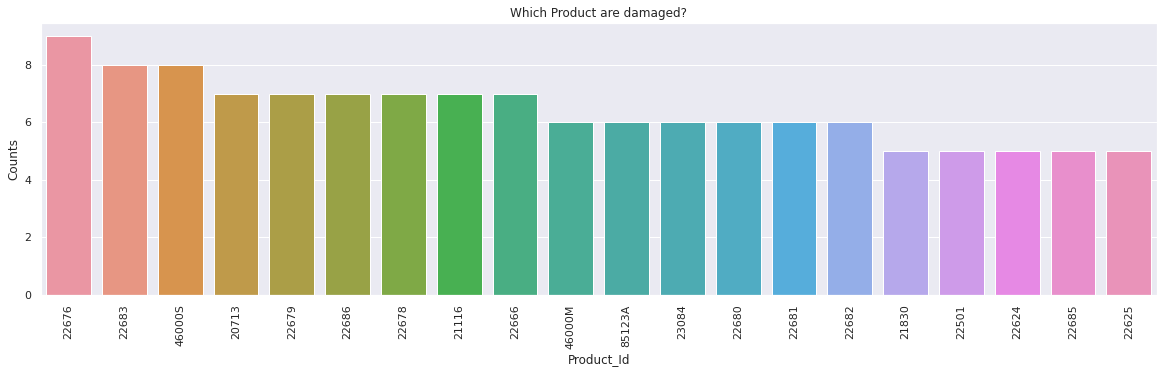

In [107]:
Damaged_Id = Damaged.Product_Id.value_counts().sort_values(ascending=False).iloc[0:20]
plt.figure(figsize=(20,5))
sns.barplot(Damaged_Id.index,Damaged_Id.values,order = Damaged_Id.index)
plt.ylabel("Counts")
plt.xlabel('Product_Id')
plt.title("Which Product are damaged?");
plt.xticks(rotation=90);

In [108]:
def unique_counts(data):
   for i in data.columns:
       count = data[i].nunique()
       print(i, ": ", count)
unique_counts(Clean_sales)

Transaction_Id :  18402
Product_Id :  3659
Description :  3871
quantity :  299
transaction_timestamp :  17166
Unit_Price :  355
Customer_Id :  4334
country :  37
IsCancelled :  1
Revenue :  2855
Year :  2
Quarter :  4
Month :  12
Week :  51
Weekday :  6
Day :  31
Dayofyear :  298
Date :  305


In [109]:
Clean_sales.drop(["IsCancelled"],axis = 1,inplace = True)

In [110]:
Guest_sales.describe()

,quantity,Unit_Price,Customer_Id,Revenue,Year,Quarter,Month,Week,Weekday,Day,Dayofyear
count,117859.000000,117859.000000,0.0,117859.000000,117859.000000,117859.000000,117859.000000,117859.000000,117859.000000,117859.000000,117859.000000
mean,1.995138,3.756508,NaN,6.908579,2010.885100,2.777997,7.394166,30.098881,1.900076,14.925326,208.707142
std,1.643120,2.717500,NaN,7.811259,0.318903,1.179320,3.771882,16.266412,1.465181,8.673360,114.099108
min,1.000000,0.060000,NaN,0.060000,2010.000000,1.000000,1.000000,1.000000,0.000000,1.000000,4.000000
25%,1.000000,1.630000,NaN,2.460000,2011.000000,2.000000,4.000000,16.000000,1.000000,8.000000,108.000000
50%,1.000000,3.290000,NaN,4.210000,2011.000000,3.000000,8.000000,32.000000,2.000000,14.000000,222.000000
75%,2.000000,4.960000,NaN,8.290000,2011.000000,4.000000,11.000000,46.000000,3.000000,22.000000,320.000000
max,9.000000,13.130000,NaN,116.550000,2011.000000,4.000000,12.000000,51.000000,6.000000,31.000000,357.000000


In [111]:
unique_counts(Guest_sales)

Transaction_Id :  1331
Product_Id :  3257
Description :  3228
quantity :  9
transaction_timestamp :  1232
Unit_Price :  219
Customer_Id :  0
country :  8
IsCancelled :  1
Revenue :  763
Year :  2
Quarter :  4
Month :  12
Week :  51
Weekday :  6
Day :  31
Dayofyear :  264
Date :  271


In [112]:
unique_counts(Cancelled_orders)

Transaction_Id :  3418
Product_Id :  1935
Description :  1960
quantity :  133
transaction_timestamp :  3358
Unit_Price :  188
Customer_Id :  1528
country :  28
IsCancelled :  1


In [113]:
sales.Transaction_Id.nunique()

23923

In [114]:
3694/24306

0.151978935242327

In [115]:
Guest_sales.shape

(117859, 18)

In [116]:
Clean_sales.shape

(391150, 17)

In [117]:
Guest_sales.drop(["Customer_Id","IsCancelled"],axis = 1,inplace = True)

In [118]:
Promotions.shape

(33, 9)

In [119]:
Promotions.describe()

,quantity,Unit_Price,Customer_Id
count,33.000000,33.0,33.000000
mean,420.515152,0.0,14252.575758
std,2176.713608,0.0,1659.811925
min,1.000000,0.0,12415.000000
25%,2.000000,0.0,13081.000000
50%,11.000000,0.0,13985.000000
75%,36.000000,0.0,14911.000000
max,12540.000000,0.0,18059.000000


In [120]:
Promotions.quantity = Promotions.quantity.apply(lambda x: abs(x))

In [121]:
Promotions.describe()

,quantity,Unit_Price,Customer_Id
count,33.000000,33.0,33.000000
mean,420.515152,0.0,14252.575758
std,2176.713608,0.0,1659.811925
min,1.000000,0.0,12415.000000
25%,2.000000,0.0,13081.000000
50%,11.000000,0.0,13985.000000
75%,36.000000,0.0,14911.000000
max,12540.000000,0.0,18059.000000


In [122]:
Promotions['Revenue'] = Promotions['Unit_Price']*Promotions['quantity']

In [123]:
Promotions['Revenue'].sum()/Clean_sales['Revenue'].sum()

0.0

In [124]:
Clean_sales['Revenue'].sum()+Guest_sales['Revenue'].sum()

9551465.84

In [125]:
Promotions['Revenue'].sum()/(Clean_sales['Revenue'].sum()+Guest_sales['Revenue'].sum())

0.0

In [126]:
le = LabelEncoder()
le.fit(Clean_sales['country'])

LabelEncoder()

In [127]:
l = [i for i in range(38)]
dict(zip(list(le.classes_), l))

{'Australia': 0,
 'Austria': 1,
 'Bahrain': 2,
 'Belgium': 3,
 'Brazil': 4,
 'Canada': 5,
 'Channel Islands': 6,
 'Cyprus': 7,
 'Czech Republic': 8,
 'Denmark': 9,
 'EIRE': 10,
 'European Community': 11,
 'Finland': 12,
 'France': 13,
 'Germany': 14,
 'Greece': 15,
 'Iceland': 16,
 'Israel': 17,
 'Italy': 18,
 'Japan': 19,
 'Lebanon': 20,
 'Lithuania': 21,
 'Malta': 22,
 'Netherlands': 23,
 'Norway': 24,
 'Poland': 25,
 'Portugal': 26,
 'RSA': 27,
 'Saudi Arabia': 28,
 'Singapore': 29,
 'Spain': 30,
 'Sweden': 31,
 'Switzerland': 32,
 'USA': 33,
 'United Arab Emirates': 34,
 'United Kingdom': 35,
 'Unspecified': 36}

In [128]:
Clean_sales['country'] = le.transform(Clean_sales['country'])

In [129]:
with open('labelencoder.pickle', 'wb') as g:
    pickle.dump(le, g)

In [130]:
Clean_sales.describe()

,quantity,Unit_Price,Customer_Id,country,Revenue,Year,Quarter,Month,Week,Weekday,Day,Dayofyear
count,391150.000000,391150.000000,391150.000000,391150.000000,391150.000000,391150.000000,391150.000000,391150.000000,391150.000000,391150.000000,391150.000000,391150.000000
mean,13.145300,2.874372,15295.171456,32.875907,22.337281,2010.934631,2.852755,7.602459,30.921866,2.607698,15.043433,215.126131
std,180.807831,4.284738,1710.339033,6.671948,310.932442,0.247176,1.121338,3.414883,14.749733,1.924631,8.652538,103.360022
min,1.000000,0.040000,12346.000000,0.000000,0.060000,2010.000000,1.000000,1.000000,1.000000,0.000000,1.000000,4.000000
25%,2.000000,1.250000,13969.000000,35.000000,4.950000,2011.000000,2.000000,5.000000,19.000000,1.000000,7.000000,130.000000
50%,6.000000,1.950000,15159.000000,35.000000,11.900000,2011.000000,3.000000,8.000000,34.000000,2.000000,15.000000,240.000000
75%,12.000000,3.750000,16794.000000,35.000000,19.800000,2011.000000,4.000000,11.000000,44.000000,4.000000,22.000000,308.000000
max,80995.000000,649.500000,18287.000000,36.000000,168469.600000,2011.000000,4.000000,12.000000,51.000000,6.000000,31.000000,357.000000


1.3.2 RFM Principle

[](http://)I'll implement here the RFM principle to classify the customers in this database. This part is inspired by the work of Miljan Stojiljkovic. RFM stands for Recency, Frequency and Monetary. It is a customer segmentation technique that uses past purchase behavior to divide customers into groups.

In [131]:
Clean_sales['transaction_timestamp'].min()

Timestamp('2010-12-01 08:26:00')

In [132]:
Clean_sales['transaction_timestamp'].max()

Timestamp('2011-12-09 12:50:00')

In [133]:
NOW = dt.datetime(2011,12,10)
Clean_sales['transaction_timestamp'] = pd.to_datetime(Clean_sales['transaction_timestamp'])

In [134]:
Clean_sales.head(1)

,Transaction_Id,Product_Id,Description,quantity,transaction_timestamp,Unit_Price,Customer_Id,country,Revenue,Year,Quarter,Month,Week,Weekday,Day,Dayofyear,Date
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,35,15.3,2010,4,12,48,2,1,335,2010-12-01


Product Categeory

In [135]:
product_id = Clean_sales[['Product_Id','quantity','Unit_Price']]
product_id.head()

,Product_Id,quantity,Unit_Price
0,85123A,6,2.55
1,71053,6,3.39
2,84406B,8,2.75
3,84029G,6,3.39
4,84029E,6,3.39


In [136]:
custom_aggregation = {}
custom_aggregation["Product_Id"] = lambda x:len(x)
custom_aggregation["quantity"] = "sum"
custom_aggregation["Unit_Price"] = "median"

In [137]:
product_id = product_id.groupby("Product_Id").agg(custom_aggregation)

In [138]:
product_id.columns = ["orders", "total_Quantity", "Median_UnitPrice"]
product_id.head()

,orders,total_Quantity,Median_UnitPrice
Product_Id,,,
10002,49,823,0.85
10080,21,291,0.39
10120,29,192,0.21
10125,63,1225,0.85
10133,122,2373,0.42


In [139]:
def RScore(x,p,d):
    if x <= d[p][0.20]:
        return 1
    elif x <= d[p][0.40]:
        return 2
    elif x <= d[p][0.60]: 
        return 3
    elif x <= d[p][0.80]:
        return 4
    else:
        return 5

In [140]:
quantiles = product_id.quantile(q=[0.20,0.40,0.60,0.80])
quantiles = quantiles.to_dict()
quantiles

{'Median_UnitPrice': {0.2: 0.85, 0.4: 1.45, 0.6: 2.55, 0.8: 4.65},
 'orders': {0.2: 8.0, 0.4: 31.0, 0.6: 75.0, 0.8: 165.0},
 'total_Quantity': {0.2: 38.0,
  0.4: 212.0,
  0.6: 683.7999999999997,
  0.8: 1805.6000000000004}}

In [141]:
product_id['o_quartile'] = product_id['orders'].apply(RScore, args=('orders',quantiles,))
product_id['tq_quartile'] = product_id['total_Quantity'].apply(RScore, args=('total_Quantity',quantiles,))
product_id['mup_quartile'] = product_id['Median_UnitPrice'].apply(RScore, args=('Median_UnitPrice',quantiles,))
product_id.head()

,orders,total_Quantity,Median_UnitPrice,o_quartile,tq_quartile,mup_quartile
Product_Id,,,,,,
10002,49,823,0.85,3,4,1
10080,21,291,0.39,2,3,1
10120,29,192,0.21,2,2,1
10125,63,1225,0.85,3,4,1
10133,122,2373,0.42,4,5,1


In [142]:
product_id['cluster'] = product_id['o_quartile']*product_id['tq_quartile']*product_id['mup_quartile']
product_id.head()

,orders,total_Quantity,Median_UnitPrice,o_quartile,tq_quartile,mup_quartile,cluster
Product_Id,,,,,,,
10002,49,823,0.85,3,4,1,12
10080,21,291,0.39,2,3,1,6
10120,29,192,0.21,2,2,1,4
10125,63,1225,0.85,3,4,1,12
10133,122,2373,0.42,4,5,1,20


In [143]:
product_id.cluster.nunique()

30

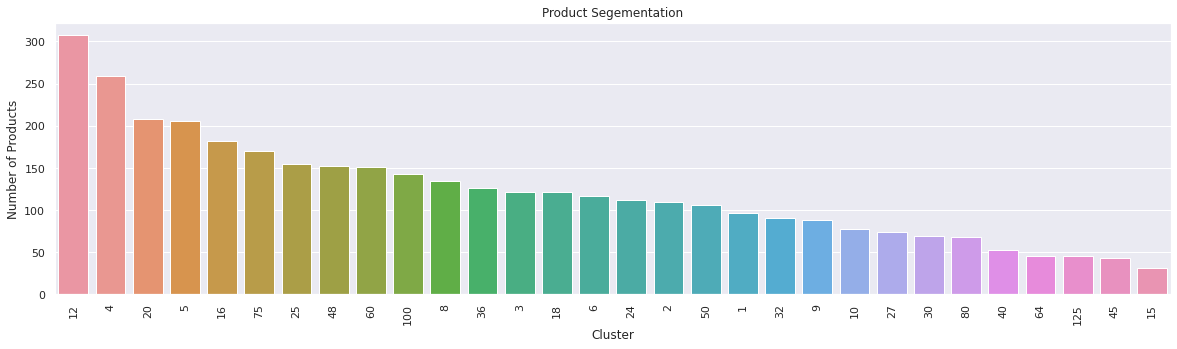

In [144]:
plt.figure(figsize=(20,5))
Product_Id = product_id.cluster.value_counts()
sns.barplot(Product_Id.index,Product_Id.values,order = Product_Id.index)
plt.ylabel("Number of Products")
plt.xlabel('Cluster')
plt.title("Product Segementation");
plt.xticks(rotation=90);

RFM for customer

In [145]:
NOW = dt.datetime(2011,12,10)
Clean_sales['transaction_timestamp'] = pd.to_datetime(Clean_sales['transaction_timestamp'])

In [146]:
custom_aggregation = {}
custom_aggregation["transaction_timestamp"] = ["min","max",lambda x: len(x)]
custom_aggregation["Revenue"] = "sum"

custom_aggregation

{'Revenue': 'sum',
 'transaction_timestamp': ['min', 'max', <function __main__.<lambda>>]}

In [147]:
Clean_sales.shape

(391150, 17)

In [148]:
Clean_sales.Customer_Id.nunique()

4334

In [149]:
rfmTable = Clean_sales.groupby("Customer_Id").agg(custom_aggregation)
rfmTable.head()

transaction_timestamp                                  Revenue
                              min                 max <lambda_0>       sum
Customer_Id                                                               
12346.0       2011-01-18 10:01:00 2011-01-18 10:01:00          1  77183.60
12347.0       2010-12-07 14:57:00 2011-12-07 15:52:00        182   4310.00
12348.0       2010-12-16 19:09:00 2011-09-25 13:13:00         27   1437.24
12349.0       2011-11-21 09:51:00 2011-11-21 09:51:00         72   1457.55
12350.0       2011-02-02 16:01:00 2011-02-02 16:01:00         16    294.40

In [150]:
rfmTable.shape

(4334, 4)

In [151]:
rfmTable.columns = ["min_time", "max_time", "frequency", "monetary_value"]

In [152]:
rfmTable["max_Recency"] = (NOW - rfmTable["min_time"]).dt.days
rfmTable["min_Recency"] = (NOW - rfmTable["max_time"]).dt.days

In [153]:
rfmTable.head(5)

,min_time,max_time,frequency,monetary_value,max_Recency,min_Recency
Customer_Id,,,,,,
12346.0,2011-01-18 10:01:00,2011-01-18 10:01:00,1,77183.60,325,325
12347.0,2010-12-07 14:57:00,2011-12-07 15:52:00,182,4310.00,367,2
12348.0,2010-12-16 19:09:00,2011-09-25 13:13:00,27,1437.24,358,75
12349.0,2011-11-21 09:51:00,2011-11-21 09:51:00,72,1457.55,18,18
12350.0,2011-02-02 16:01:00,2011-02-02 16:01:00,16,294.40,310,310


In [154]:
custom_aggregation = {}

custom_aggregation["Recency"] = ["min", "max"]
custom_aggregation["transaction_timestamp"] = lambda x: len(x)
custom_aggregation["Revenue"] = "sum"

In [155]:
rfmTable_final = rfmTable.drop(['min_time','max_time'],axis = 1)

In [156]:
rfmTable_final.head(5)

,frequency,monetary_value,max_Recency,min_Recency
Customer_Id,,,,
12346.0,1,77183.60,325,325
12347.0,182,4310.00,367,2
12348.0,27,1437.24,358,75
12349.0,72,1457.55,18,18
12350.0,16,294.40,310,310


In [157]:
rfmTable_final.shape

(4334, 4)

In [158]:
quantiles = rfmTable_final.quantile(q=[0.25,0.5,0.75])
quantiles = quantiles.to_dict()
quantiles

{'frequency': {0.25: 17.0, 0.5: 41.0, 0.75: 98.0},
 'max_Recency': {0.25: 112.0, 0.5: 248.0, 0.75: 326.0},
 'min_Recency': {0.25: 17.0, 0.5: 50.0, 0.75: 142.0},
 'monetary_value': {0.25: 304.23999999999995,
  0.5: 662.5649999999999,
  0.75: 1631.6225000000004}}

In [159]:
segmented_rfm = rfmTable_final

In [160]:
segmented_rfm.head()

,frequency,monetary_value,max_Recency,min_Recency
Customer_Id,,,,
12346.0,1,77183.60,325,325
12347.0,182,4310.00,367,2
12348.0,27,1437.24,358,75
12349.0,72,1457.55,18,18
12350.0,16,294.40,310,310


In [161]:
def RScore(x,p,d):
    if x <= d[p][0.25]:
        return 1
    elif x <= d[p][0.50]:
        return 2
    elif x <= d[p][0.75]: 
        return 3
    else:
        return 4
    
def FMScore(x,p,d):
    if x <= d[p][0.25]:
        return 4
    elif x <= d[p][0.50]:
        return 3
    elif x <= d[p][0.75]: 
        return 2
    else:
        return 1

In [162]:
segmented_rfm['r_quartile'] = segmented_rfm['min_Recency'].apply(RScore, args=('min_Recency',quantiles,))
segmented_rfm['f_quartile'] = segmented_rfm['frequency'].apply(FMScore, args=('frequency',quantiles,))
segmented_rfm['m_quartile'] = segmented_rfm['monetary_value'].apply(FMScore, args=('monetary_value',quantiles,))
segmented_rfm.head()

,frequency,monetary_value,max_Recency,min_Recency,r_quartile,f_quartile,m_quartile
Customer_Id,,,,,,,
12346.0,1,77183.60,325,325,4,4,1
12347.0,182,4310.00,367,2,1,1,1
12348.0,27,1437.24,358,75,3,3,2
12349.0,72,1457.55,18,18,2,2,2
12350.0,16,294.40,310,310,4,4,4


In [163]:
segmented_rfm['RFMScore'] = segmented_rfm.r_quartile.map(str) + segmented_rfm.f_quartile.map(str) + segmented_rfm.m_quartile.map(str)
segmented_rfm.head()

,frequency,monetary_value,max_Recency,min_Recency,r_quartile,f_quartile,m_quartile,RFMScore
Customer_Id,,,,,,,,
12346.0,1,77183.60,325,325,4,4,1,441
12347.0,182,4310.00,367,2,1,1,1,111
12348.0,27,1437.24,358,75,3,3,2,332
12349.0,72,1457.55,18,18,2,2,2,222
12350.0,16,294.40,310,310,4,4,4,444


In [164]:
segmented_rfm[segmented_rfm['RFMScore']=='111'].sort_values('monetary_value', ascending=False)

,frequency,monetary_value,max_Recency,min_Recency,r_quartile,f_quartile,m_quartile,RFMScore
Customer_Id,,,,,,,,
14646.0,2060,279138.02,354,1,1,1,1,111
18102.0,431,259657.30,367,0,1,1,1,111
17450.0,336,194390.79,367,8,1,1,1,111
14911.0,5584,136161.83,373,1,1,1,1,111
14156.0,1382,116560.08,371,9,1,1,1,111
...,...,...,...,...,...,...,...,...
15214.0,110,1661.44,242,1,1,1,1,111
16115.0,279,1660.88,292,9,1,1,1,111
16813.0,426,1652.18,204,8,1,1,1,111


In [165]:
segmented_rfm.head(5)

,frequency,monetary_value,max_Recency,min_Recency,r_quartile,f_quartile,m_quartile,RFMScore
Customer_Id,,,,,,,,
12346.0,1,77183.60,325,325,4,4,1,441
12347.0,182,4310.00,367,2,1,1,1,111
12348.0,27,1437.24,358,75,3,3,2,332
12349.0,72,1457.55,18,18,2,2,2,222
12350.0,16,294.40,310,310,4,4,4,444


In [166]:
segmented_rfm = segmented_rfm.reset_index()

In [167]:
segmented_rfm.head(5)

,Customer_Id,frequency,monetary_value,max_Recency,min_Recency,r_quartile,f_quartile,m_quartile,RFMScore
0,12346.0,1,77183.60,325,325,4,4,1,441
1,12347.0,182,4310.00,367,2,1,1,1,111
2,12348.0,27,1437.24,358,75,3,3,2,332
3,12349.0,72,1457.55,18,18,2,2,2,222
4,12350.0,16,294.40,310,310,4,4,4,444


In [168]:
segmented_rfm['RFMScore'].value_counts()

111    442
444    382
211    219
433    205
344    182
      ... 
241      8
431      7
141      6
413      3
114      3
Name: RFMScore, Length: 61, dtype: int64

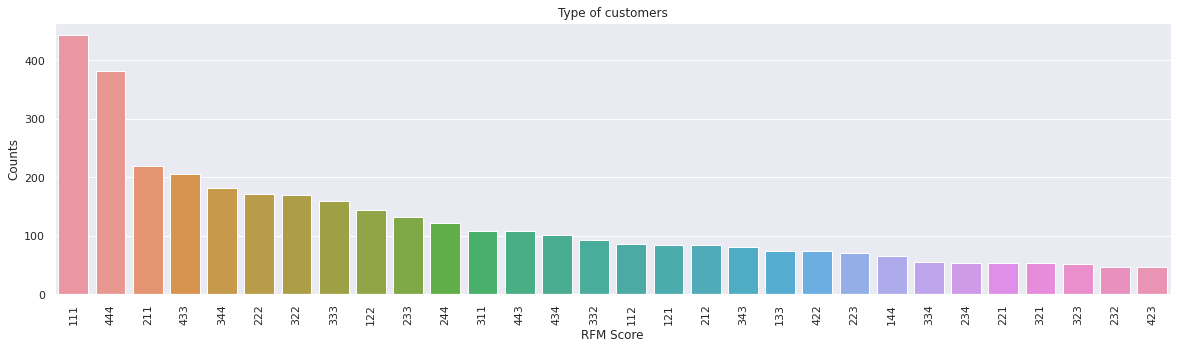

In [169]:
RFM_score = segmented_rfm['RFMScore'].value_counts().iloc[:30]
plt.figure(figsize=(20,5))
sns.barplot(RFM_score.index, RFM_score.values,order = RFM_score.index)
plt.ylabel("Counts")
plt.xlabel('RFM Score')
plt.title("Type of customers");
plt.xticks(rotation=90);

In [170]:
Clean_sales = pd.merge(Clean_sales,segmented_rfm, on='Customer_Id')

In [171]:
Clean_sales.columns

Index(['Transaction_Id', 'Product_Id', 'Description', 'quantity',
       'transaction_timestamp', 'Unit_Price', 'Customer_Id', 'country',
       'Revenue', 'Year', 'Quarter', 'Month', 'Week', 'Weekday', 'Day',
       'Dayofyear', 'Date', 'frequency', 'monetary_value', 'max_Recency',
       'min_Recency', 'r_quartile', 'f_quartile', 'm_quartile', 'RFMScore'],
      dtype='object')

In [172]:
Clean_sales = Clean_sales.drop(columns=['r_quartile', 'f_quartile', 'm_quartile'])

In [173]:
Clean_sales.head()

,Transaction_Id,Product_Id,Description,quantity,transaction_timestamp,Unit_Price,Customer_Id,country,Revenue,Year,Quarter,Month,Week,Weekday,Day,Dayofyear,Date,frequency,monetary_value,max_Recency,min_Recency,RFMScore
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,35,15.30,2010,4,12,48,2,1,335,2010-12-01,297,5391.21,373,372,411
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,35,20.34,2010,4,12,48,2,1,335,2010-12-01,297,5391.21,373,372,411
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,35,22.00,2010,4,12,48,2,1,335,2010-12-01,297,5391.21,373,372,411
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,35,20.34,2010,4,12,48,2,1,335,2010-12-01,297,5391.21,373,372,411
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,35,20.34,2010,4,12,48,2,1,335,2010-12-01,297,5391.21,373,372,411


In [174]:
product_id.head()

,orders,total_Quantity,Median_UnitPrice,o_quartile,tq_quartile,mup_quartile,cluster
Product_Id,,,,,,,
10002,49,823,0.85,3,4,1,12
10080,21,291,0.39,2,3,1,6
10120,29,192,0.21,2,2,1,4
10125,63,1225,0.85,3,4,1,12
10133,122,2373,0.42,4,5,1,20


In [175]:
product_id.shape

(3659, 7)

In [176]:
product_cluster = product_id.drop(['orders','total_Quantity','Median_UnitPrice','o_quartile','tq_quartile','mup_quartile'],axis = 1)
product_cluster = product_cluster.to_dict()

In [177]:
product_id.cluster.nunique()

30

In [178]:
cluster = Clean_sales['Product_Id'].apply(lambda x : product_cluster['cluster'][x])
cluster

0         100
1          80
2         100
3         100
4         100
         ... 
391145     50
391146     25
391147     25
391148     75
391149     48
Name: Product_Id, Length: 391150, dtype: int64

In [179]:
df2 = pd.get_dummies(cluster, prefix="Cluster").mul(Clean_sales["Revenue"], 0)
df2 = pd.concat([Clean_sales['Customer_Id'], df2], axis=1)
df2_grouped = df2.groupby('Customer_Id').sum()

In [180]:
df2_grouped

,Cluster_1,Cluster_2,Cluster_3,Cluster_4,Cluster_5,Cluster_6,Cluster_8,Cluster_9,Cluster_10,Cluster_12,Cluster_15,Cluster_16,Cluster_18,Cluster_20,Cluster_24,Cluster_25,Cluster_27,Cluster_30,Cluster_32,Cluster_36,Cluster_40,Cluster_45,Cluster_48,Cluster_50,Cluster_60,Cluster_64,Cluster_75,Cluster_80,Cluster_100,Cluster_125
Customer_Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
12346.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,77183.6,0.0,0.00,0.00,0.00,0.00,0.00
12347.0,0.0,0.0,0.0,0.0,0.0,61.20,37.50,25.44,55.80,176.28,16.80,21.08,44.90,86.94,51.00,350.20,0.00,80.55,81.00,469.20,75.0,0.00,288.68,439.4,263.4,60.00,466.14,335.04,593.40,231.05
12348.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,61.20,0.00,0.00,0.00,0.00,0.00,41.76,104.40,580.28,0.00,0.00,0.00,0.00,0.0,0.00,0.00,649.6,0.0,0.00,0.00,0.00,0.00,0.00
12349.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.00,9.48,0.00,20.70,0.00,58.62,12.48,53.90,0.00,0.00,0.0,63.80,78.06,182.2,218.3,57.90,246.22,12.75,236.69,206.45
12350.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,25.20,0.00,25.20,0.00,26.20,17.40,0.00,15.00,20.40,0.00,0.00,0.00,25.20,0.0,0.00,45.00,30.0,0.0,0.00,64.80,0.00,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18280.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,17.70,0.0,14.85,17.70,0.0,19.9,0.00,15.30,15.00,56.45,23.70
18281.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,15.12,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.0,33.9,0.00,31.80,0.00,0.00,0.00
18282.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,12.75,0.00,13.92,0.00,0.00,5.04,0.00,29.59,0.00,0.00,0.00,13.50,0.0,0.00,0.00,0.0,0.0,0.00,0.00,17.70,60.05,25.50


In [181]:
df2_grouped.shape

(4334, 30)

In [182]:
df2_grouped_final = df2_grouped.div(df2_grouped.sum(axis=1), axis=0)
df2_grouped_final = df2_grouped_final.fillna(0)

In [183]:
df2_grouped_final.head()

,Cluster_1,Cluster_2,Cluster_3,Cluster_4,Cluster_5,Cluster_6,Cluster_8,Cluster_9,Cluster_10,Cluster_12,Cluster_15,Cluster_16,Cluster_18,Cluster_20,Cluster_24,Cluster_25,Cluster_27,Cluster_30,Cluster_32,Cluster_36,Cluster_40,Cluster_45,Cluster_48,Cluster_50,Cluster_60,Cluster_64,Cluster_75,Cluster_80,Cluster_100,Cluster_125
Customer_Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
12346.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
12347.0,0.0,0.0,0.0,0.0,0.0,0.0142,0.008701,0.005903,0.012947,0.040900,0.003898,0.004891,0.010418,0.020172,0.011833,0.081253,0.000000,0.018689,0.018794,0.108863,0.017401,0.000000,0.066979,0.101949,0.061114,0.013921,0.108153,0.077735,0.137680,0.053608
12348.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.000000,0.042582,0.000000,0.000000,0.000000,0.000000,0.000000,0.029056,0.072639,0.403746,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.451977,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
12349.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.006504,0.000000,0.014202,0.000000,0.040218,0.008562,0.036980,0.000000,0.000000,0.000000,0.043772,0.053556,0.125004,0.149772,0.039724,0.168927,0.008748,0.162389,0.141642
12350.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.000000,0.085598,0.000000,0.085598,0.000000,0.088995,0.059103,0.000000,0.050951,0.069293,0.000000,0.000000,0.000000,0.085598,0.000000,0.000000,0.152853,0.101902,0.000000,0.000000,0.220109,0.000000,0.000000,0.000000


In [184]:
custom_aggregation = {}
custom_aggregation["transaction_timestamp"] = ["min","max",lambda x: len(x)]
custom_aggregation["Revenue"] = ["min","max","mean","sum"]
custom_aggregation["country"] = "median"
custom_aggregation["quantity"] = "sum"
custom_aggregation

{'Revenue': ['min', 'max', 'mean', 'sum'],
 'country': 'median',
 'quantity': 'sum',
 'transaction_timestamp': ['min', 'max', <function __main__.<lambda>>]}

In [185]:
df_grouped_final = Clean_sales.groupby("Customer_Id").agg(custom_aggregation)

In [186]:
df_grouped_final.head()

transaction_timestamp                      ... country quantity
                              min                 max  ...  median      sum
Customer_Id                                            ...                 
12346.0       2011-01-18 10:01:00 2011-01-18 10:01:00  ...      35    74215
12347.0       2010-12-07 14:57:00 2011-12-07 15:52:00  ...      16     2458
12348.0       2010-12-16 19:09:00 2011-09-25 13:13:00  ...      12     2332
12349.0       2011-11-21 09:51:00 2011-11-21 09:51:00  ...      18      630
12350.0       2011-02-02 16:01:00 2011-02-02 16:01:00  ...      24      196

[5 rows x 9 columns]

In [187]:
df_grouped_final.columns = ["min_time", "max_time","frequency","min","max","mean","monetary_value","country","quantity"]
df_grouped_final["max_Recency"] = (NOW - rfmTable["min_time"]).dt.days
df_grouped_final["min_Recency"] = (NOW - rfmTable["max_time"]).dt.days

In [188]:
df_grouped_final.head(5)

,min_time,max_time,frequency,min,max,mean,monetary_value,country,quantity,max_Recency,min_Recency
Customer_Id,,,,,,,,,,,
12346.0,2011-01-18 10:01:00,2011-01-18 10:01:00,1,77183.60,77183.6,77183.600000,77183.60,35,74215,325,325
12347.0,2010-12-07 14:57:00,2011-12-07 15:52:00,182,5.04,249.6,23.681319,4310.00,16,2458,367,2
12348.0,2010-12-16 19:09:00,2011-09-25 13:13:00,27,13.20,150.0,53.231111,1437.24,12,2332,358,75
12349.0,2011-11-21 09:51:00,2011-11-21 09:51:00,72,6.64,63.8,20.243750,1457.55,18,630,18,18
12350.0,2011-02-02 16:01:00,2011-02-02 16:01:00,16,8.50,25.2,18.400000,294.40,24,196,310,310


In [189]:
df_grouped_final.drop(["min_time","max_time"],axis = 1,inplace = True)

In [190]:
df2_grouped_final.head(5)

,Cluster_1,Cluster_2,Cluster_3,Cluster_4,Cluster_5,Cluster_6,Cluster_8,Cluster_9,Cluster_10,Cluster_12,Cluster_15,Cluster_16,Cluster_18,Cluster_20,Cluster_24,Cluster_25,Cluster_27,Cluster_30,Cluster_32,Cluster_36,Cluster_40,Cluster_45,Cluster_48,Cluster_50,Cluster_60,Cluster_64,Cluster_75,Cluster_80,Cluster_100,Cluster_125
Customer_Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
12346.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
12347.0,0.0,0.0,0.0,0.0,0.0,0.0142,0.008701,0.005903,0.012947,0.040900,0.003898,0.004891,0.010418,0.020172,0.011833,0.081253,0.000000,0.018689,0.018794,0.108863,0.017401,0.000000,0.066979,0.101949,0.061114,0.013921,0.108153,0.077735,0.137680,0.053608
12348.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.000000,0.042582,0.000000,0.000000,0.000000,0.000000,0.000000,0.029056,0.072639,0.403746,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.451977,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
12349.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.006504,0.000000,0.014202,0.000000,0.040218,0.008562,0.036980,0.000000,0.000000,0.000000,0.043772,0.053556,0.125004,0.149772,0.039724,0.168927,0.008748,0.162389,0.141642
12350.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.000000,0.085598,0.000000,0.085598,0.000000,0.088995,0.059103,0.000000,0.050951,0.069293,0.000000,0.000000,0.000000,0.085598,0.000000,0.000000,0.152853,0.101902,0.000000,0.000000,0.220109,0.000000,0.000000,0.000000


In [191]:
df_grouped_final.head()

,frequency,min,max,mean,monetary_value,country,quantity,max_Recency,min_Recency
Customer_Id,,,,,,,,,
12346.0,1,77183.60,77183.6,77183.600000,77183.60,35,74215,325,325
12347.0,182,5.04,249.6,23.681319,4310.00,16,2458,367,2
12348.0,27,13.20,150.0,53.231111,1437.24,12,2332,358,75
12349.0,72,6.64,63.8,20.243750,1457.55,18,630,18,18
12350.0,16,8.50,25.2,18.400000,294.40,24,196,310,310


In [192]:
df_grouped_final.shape

(4334, 9)

In [193]:
df2_grouped_final.shape

(4334, 30)

In [194]:
X1 = df_grouped_final.to_numpy()
X2 = df2_grouped_final.to_numpy()

scaler = StandardScaler()
X1 = scaler.fit_transform(X1)
X_final_std_scale = np.concatenate((X1, X2), axis=1)

In [195]:
x = list(range(2, 12))
y_std = []
for n_clusters in x:
    print("n_clusters =", n_clusters)
    
    kmeans = KMeans(init='k-means++', n_clusters = n_clusters, n_init=10)
    kmeans.fit(X_final_std_scale)
    clusters = kmeans.predict(X_final_std_scale)
    silhouette_avg = silhouette_score(X_final_std_scale, clusters)
    y_std.append(silhouette_avg)
    print("The average silhouette_score is :", silhouette_avg, "with Std Scaling")

n_clusters = 2
The average silhouette_score is : 0.9683741338199047 with Std Scaling
n_clusters = 3
The average silhouette_score is : 0.8880251973253811 with Std Scaling
n_clusters = 4
The average silhouette_score is : 0.8879965866535696 with Std Scaling
n_clusters = 5
The average silhouette_score is : 0.28587986075408556 with Std Scaling
n_clusters = 6
The average silhouette_score is : 0.43458052424282745 with Std Scaling
n_clusters = 7
The average silhouette_score is : 0.4345648485850916 with Std Scaling
n_clusters = 8
The average silhouette_score is : 0.43518271236109607 with Std Scaling
n_clusters = 9
The average silhouette_score is : 0.44160198593344074 with Std Scaling
n_clusters = 10
The average silhouette_score is : 0.4420329239064624 with Std Scaling
n_clusters = 11
The average silhouette_score is : 0.38991058206095636 with Std Scaling


In [196]:
kmeans = KMeans(init='k-means++', n_clusters = 8, n_init=30, random_state=0)  # random state just to be able to provide cluster number durint analysis
kmeans.fit(X_final_std_scale)
clusters = kmeans.predict(X_final_std_scale)

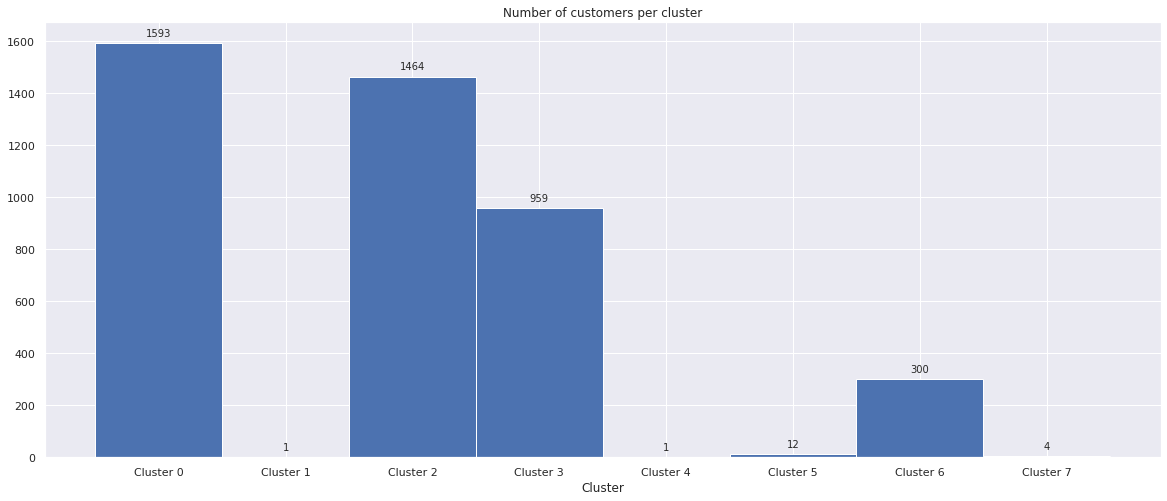

In [197]:
plt.figure(figsize = (20,8))
n, bins, patches = plt.hist(clusters, bins=8)
plt.xlabel("Cluster")
plt.title("Number of customers per cluster")
plt.xticks([rect.get_x()+ rect.get_width() / 2 for rect in patches], ["Cluster {}".format(x) for x in range(8)])

for rect in patches:
    y_value = rect.get_height()
    x_value = rect.get_x() + rect.get_width() / 2

    space = 5
    va = 'bottom'
    label = str(int(y_value))
    
    plt.annotate(
        label,                      
        (x_value, y_value),         
        xytext=(0, space),          
        textcoords="offset points", 
        ha='center',                
        va=va)

In [198]:
df_grouped_final["cluster"] = clusters

In [199]:
final_dataset = pd.concat([df_grouped_final, df2_grouped_final], axis = 1)
final_dataset.head()

,frequency,min,max,mean,monetary_value,country,quantity,max_Recency,min_Recency,cluster,Cluster_1,Cluster_2,Cluster_3,Cluster_4,Cluster_5,Cluster_6,Cluster_8,Cluster_9,Cluster_10,Cluster_12,Cluster_15,Cluster_16,Cluster_18,Cluster_20,Cluster_24,Cluster_25,Cluster_27,Cluster_30,Cluster_32,Cluster_36,Cluster_40,Cluster_45,Cluster_48,Cluster_50,Cluster_60,Cluster_64,Cluster_75,Cluster_80,Cluster_100,Cluster_125
Customer_Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
12346.0,1,77183.60,77183.6,77183.600000,77183.60,35,74215,325,325,1,0.0,0.0,0.0,0.0,0.0,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
12347.0,182,5.04,249.6,23.681319,4310.00,16,2458,367,2,6,0.0,0.0,0.0,0.0,0.0,0.0142,0.008701,0.005903,0.012947,0.040900,0.003898,0.004891,0.010418,0.020172,0.011833,0.081253,0.000000,0.018689,0.018794,0.108863,0.017401,0.000000,0.066979,0.101949,0.061114,0.013921,0.108153,0.077735,0.137680,0.053608
12348.0,27,13.20,150.0,53.231111,1437.24,12,2332,358,75,6,0.0,0.0,0.0,0.0,0.0,0.0000,0.000000,0.042582,0.000000,0.000000,0.000000,0.000000,0.000000,0.029056,0.072639,0.403746,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.451977,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
12349.0,72,6.64,63.8,20.243750,1457.55,18,630,18,18,6,0.0,0.0,0.0,0.0,0.0,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.006504,0.000000,0.014202,0.000000,0.040218,0.008562,0.036980,0.000000,0.000000,0.000000,0.043772,0.053556,0.125004,0.149772,0.039724,0.168927,0.008748,0.162389,0.141642
12350.0,16,8.50,25.2,18.400000,294.40,24,196,310,310,3,0.0,0.0,0.0,0.0,0.0,0.0000,0.000000,0.085598,0.000000,0.085598,0.000000,0.088995,0.059103,0.000000,0.050951,0.069293,0.000000,0.000000,0.000000,0.085598,0.000000,0.000000,0.152853,0.101902,0.000000,0.000000,0.220109,0.000000,0.000000,0.000000


In [200]:
final_dataset.shape

(4334, 40)

In [201]:
final_dataset_V2 = final_dataset.reset_index()

In [202]:
final_dataset_V2.to_csv("final_dataset_V2.csv",index=False)

In [203]:
with open('Clean_sales.pickle', 'wb') as f:
    pickle.dump(Clean_sales, f)

Text(0.5, 1.0, 'Visualization of the clustering with TSNE')

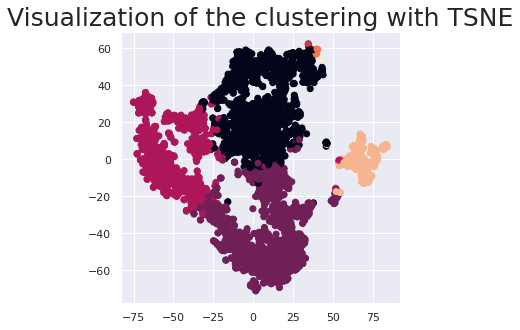

In [204]:
tsne = TSNE(n_components=2)
proj = tsne.fit_transform(X_final_std_scale)

plt.figure(figsize=(5,5))
plt.scatter(proj[:,0], proj[:,1], c=clusters)
plt.title("Visualization of the clustering with TSNE", fontsize="25")

In [205]:
final_dataset[final_dataset['cluster']==0]

,frequency,min,max,mean,monetary_value,country,quantity,max_Recency,min_Recency,cluster,Cluster_1,Cluster_2,Cluster_3,Cluster_4,Cluster_5,Cluster_6,Cluster_8,Cluster_9,Cluster_10,Cluster_12,Cluster_15,Cluster_16,Cluster_18,Cluster_20,Cluster_24,Cluster_25,Cluster_27,Cluster_30,Cluster_32,Cluster_36,Cluster_40,Cluster_45,Cluster_48,Cluster_50,Cluster_60,Cluster_64,Cluster_75,Cluster_80,Cluster_100,Cluster_125
Customer_Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
12352.0,77,9.90,38.25,17.996623,1385.74,24,526,296,36,0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.007361,0.000000,0.000000,0.014433,0.015010,0.009006,0.000000,0.019845,0.025546,0.025113,0.000000,0.064991,0.101967,0.031175,0.084431,0.150714,0.010825,0.257841,0.181744
12356.0,58,3.75,175.20,42.886724,2487.43,26,1573,325,22,0,0.0,0.0,0.000000,0.006834,0.0,0.000000,0.000000,0.028463,0.000000,0.024604,0.000000,0.037308,0.018091,0.047519,0.000000,0.077168,0.000000,0.000000,0.020101,0.057216,0.000000,0.000000,0.112349,0.147650,0.082447,0.026292,0.058615,0.055238,0.009488,0.190618
12363.0,23,13.20,69.36,24.000000,552.00,36,408,242,109,0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.031522,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.031522,0.179348,0.000000,0.000000,0.054348,0.000000,0.000000,0.000000,0.000000,0.257609,0.028804,0.000000,0.054130,0.154457,0.125652,0.082609
12409.0,109,2.88,300.00,101.584128,11072.67,32,5551,182,78,0,0.0,0.0,0.003793,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.020049,0.000260,0.000000,0.006773,0.029218,0.006773,0.067539,0.000000,0.000000,0.015964,0.000000,0.000000,0.027094,0.019833,0.068236,0.071952,0.046872,0.196999,0.046731,0.174485,0.197428
12421.0,41,5.04,35.70,15.586341,639.04,30,478,319,15,0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.015774,0.058682,0.015774,0.000000,0.032048,0.000000,0.056522,0.047603,0.082342,0.000000,0.000000,0.041625,0.000000,0.000000,0.000000,0.062437,0.172524,0.139663,0.051171,0.141306,0.054832,0.027698,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18263.0,61,3.80,41.60,19.887869,1213.16,35,1468,252,25,0,0.0,0.0,0.000000,0.015497,0.0,0.003132,0.065086,0.012364,0.000000,0.092387,0.009496,0.019288,0.074186,0.056876,0.012364,0.113851,0.016321,0.000000,0.045336,0.028587,0.045336,0.000000,0.019288,0.177058,0.000000,0.000000,0.193544,0.000000,0.000000,0.000000
18270.0,11,11.40,53.20,25.740909,283.15,35,101,266,38,0,0.0,0.0,0.000000,0.083348,0.0,0.000000,0.054035,0.000000,0.000000,0.000000,0.000000,0.117252,0.000000,0.187886,0.000000,0.000000,0.000000,0.135087,0.000000,0.117252,0.040261,0.000000,0.000000,0.105951,0.088999,0.000000,0.069928,0.000000,0.000000,0.000000
18272.0,166,6.64,67.50,18.545663,3078.58,35,2050,246,2,0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.004872,0.003274,0.000000,0.015020,0.021984,0.012824,0.000000,0.016722,0.004872,0.065914,0.013077,0.009647,0.019490,0.018573,0.000000,0.000000,0.027051,0.210552,0.073232,0.048919,0.128982,0.016858,0.267234,0.020902


In [206]:
final_dataset[final_dataset['cluster']==0].mean()

frequency          150.709353
min                  8.757363
max                170.777979
mean                41.224239
monetary_value    2997.007156
country             34.860013
quantity          1769.839297
max_Recency        311.914626
min_Recency         36.642812
cluster              0.000000
Cluster_1            0.000141
Cluster_2            0.000468
Cluster_3            0.000704
Cluster_4            0.002395
Cluster_5            0.002812
Cluster_6            0.002812
Cluster_8            0.004070
Cluster_9            0.004743
Cluster_10           0.006258
Cluster_12           0.015657
Cluster_15           0.004365
Cluster_16           0.016576
Cluster_18           0.008664
Cluster_20           0.032402
Cluster_24           0.011649
Cluster_25           0.074485
Cluster_27           0.008619
Cluster_30           0.013120
Cluster_32           0.017216
Cluster_36           0.020408
Cluster_40           0.016010
Cluster_45           0.008846
Cluster_48           0.037992
Cluster_50

In [207]:
temp_final_df = final_dataset.reset_index()

In [208]:
cust0 = list(temp_final_df[temp_final_df['cluster']==0]['Customer_Id'])

In [209]:
cluster0 = Clean_sales[Clean_sales['Customer_Id'].isin(cust0)]
pd.DataFrame(cluster0[['quantity', 'Unit_Price', 'Revenue', 'frequency', 'min_Recency'
         , 'monetary_value']].mean())

,0
quantity,11.743394
Unit_Price,2.852293
Revenue,19.886006
frequency,355.022609
min_Recency,24.912050
monetary_value,4961.557982


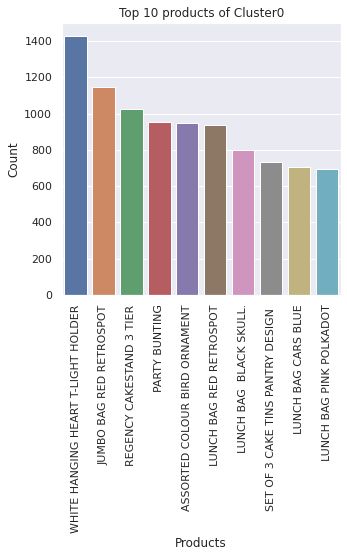

In [210]:
cluster0['Description'].value_counts()[:20]
RFM_score = cluster0['Description'].value_counts()[:10]
plt.figure(figsize=(5,5))
sns.barplot(RFM_score.index, RFM_score.values,order = RFM_score.index)
plt.ylabel("Count")
plt.xlabel('Products')
plt.title("Top 10 products of Cluster0");
plt.xticks(rotation=90);

In [211]:
custom_aggregation = {}
custom_aggregation["country"] = lambda x:x.iloc[0]
custom_aggregation["RFMScore"] = lambda x:x.iloc[0]

cluster0_grouped = cluster0.groupby("Customer_Id").agg(custom_aggregation)

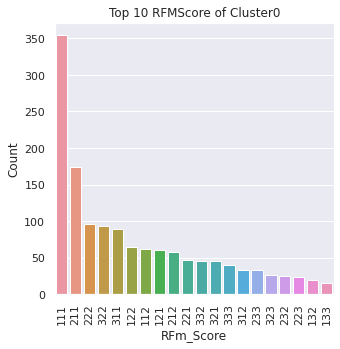

In [212]:
cluster0_grouped['RFMScore'].value_counts().iloc[:20]
RFM_score = cluster0_grouped['RFMScore'].value_counts().iloc[:20]
plt.figure(figsize=(5,5))
sns.barplot(RFM_score.index, RFM_score.values,order = RFM_score.index)
plt.ylabel("Count")
plt.xlabel('RFm_Score')
plt.title("Top 10 RFMScore of Cluster0");
plt.xticks(rotation=90);

In [213]:
cluster0_grouped['country'].value_counts()

35    1556
30      12
32       7
26       6
31       3
25       2
24       2
23       2
36       1
29       1
7        1
Name: country, dtype: int64

In [214]:
final_dataset[final_dataset['cluster']==6].mean()

frequency           80.256667
min                 12.965467
max                130.397133
mean                36.563688
monetary_value    2001.889167
country             11.683333
quantity          1157.816667
max_Recency        222.280000
min_Recency         92.296667
cluster              6.000000
Cluster_1            0.000018
Cluster_2            0.000493
Cluster_3            0.000715
Cluster_4            0.001829
Cluster_5            0.000853
Cluster_6            0.002530
Cluster_8            0.002449
Cluster_9            0.004721
Cluster_10           0.003268
Cluster_12           0.020014
Cluster_15           0.003712
Cluster_16           0.018471
Cluster_18           0.009471
Cluster_20           0.033078
Cluster_24           0.012538
Cluster_25           0.088575
Cluster_27           0.005651
Cluster_30           0.015807
Cluster_32           0.019231
Cluster_36           0.018229
Cluster_40           0.017713
Cluster_45           0.008422
Cluster_48           0.041900
Cluster_50

In [215]:
cust6 = list(temp_final_df[temp_final_df['cluster']==6]['Customer_Id'])

In [216]:
cluster6 = Clean_sales[Clean_sales['Customer_Id'].isin(cust6)]
cluster6[['quantity', 'Unit_Price', 'Revenue', 'frequency', 'min_Recency'
         , 'monetary_value']].mean()

quantity            14.426424
Unit_Price           2.893022
Revenue             24.943587
frequency          192.948499
min_Recency         46.467708
monetary_value    4636.205765
dtype: float64

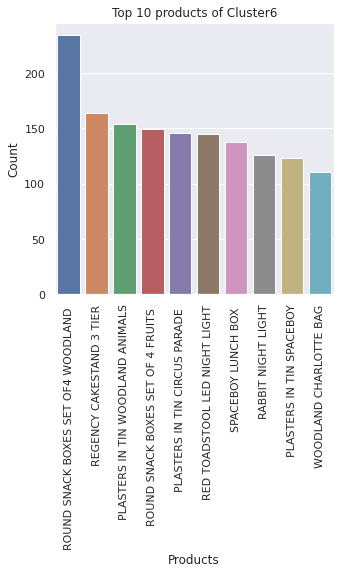

In [217]:
cluster6['Description'].value_counts()[:10]

RFM_score = cluster6['Description'].value_counts()[:10]
plt.figure(figsize=(5,5))
sns.barplot(RFM_score.index, RFM_score.values,order = RFM_score.index)
plt.ylabel("Count")
plt.xlabel('Products')
plt.title("Top 10 products of Cluster6");
plt.xticks(rotation=90);

In [218]:
custom_aggregation = {}
custom_aggregation["country"] = lambda x:x.iloc[0]
custom_aggregation["RFMScore"] = lambda x:x.iloc[0]

cluster6_grouped = cluster6.groupby("Customer_Id").agg(custom_aggregation)

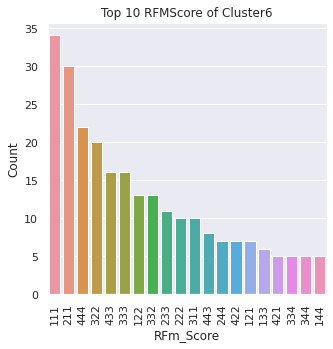

In [219]:
cluster6_grouped['RFMScore'].value_counts()
RFM_score = cluster6_grouped['RFMScore'].value_counts().iloc[:20]
plt.figure(figsize=(5,5))
sns.barplot(RFM_score.index, RFM_score.values,order = RFM_score.index)
plt.ylabel("Count")
plt.xlabel('RFm_Score')
plt.title("Top 10 RFMScore of Cluster6");
plt.xticks(rotation=90);

In [220]:
cluster6_grouped['country'].value_counts()

14    94
13    87
3     24
18    12
12    12
1      9
6      9
0      8
19     8
9      8
7      6
15     4
5      4
23     3
17     3
22     2
2      2
8      1
11     1
4      1
16     1
10     1
Name: country, dtype: int64

In [221]:
final_dataset[final_dataset['cluster']==1].mean()

frequency             1.0
min               77183.6
max               77183.6
mean              77183.6
monetary_value    77183.6
country              35.0
quantity          74215.0
max_Recency         325.0
min_Recency         325.0
cluster               1.0
Cluster_1             0.0
Cluster_2             0.0
Cluster_3             0.0
Cluster_4             0.0
Cluster_5             0.0
Cluster_6             0.0
Cluster_8             0.0
Cluster_9             0.0
Cluster_10            0.0
Cluster_12            0.0
Cluster_15            0.0
Cluster_16            0.0
Cluster_18            0.0
Cluster_20            0.0
Cluster_24            0.0
Cluster_25            0.0
Cluster_27            0.0
Cluster_30            0.0
Cluster_32            0.0
Cluster_36            0.0
Cluster_40            0.0
Cluster_45            0.0
Cluster_48            0.0
Cluster_50            1.0
Cluster_60            0.0
Cluster_64            0.0
Cluster_75            0.0
Cluster_80            0.0
Cluster_100 

In [222]:
cust1 = list(temp_final_df[temp_final_df['cluster']==1]['Customer_Id'])

In [223]:
cluster1 = Clean_sales[Clean_sales['Customer_Id'].isin(cust1)]
cluster1[['quantity', 'Unit_Price', 'Revenue', 'frequency', 'min_Recency'
         , 'monetary_value']].mean()

quantity          74215.00
Unit_Price            1.04
Revenue           77183.60
frequency             1.00
min_Recency         325.00
monetary_value    77183.60
dtype: float64

In [224]:
cluster1['Description'].value_counts()[:10]

MEDIUM CERAMIC TOP STORAGE JAR    1
Name: Description, dtype: int64

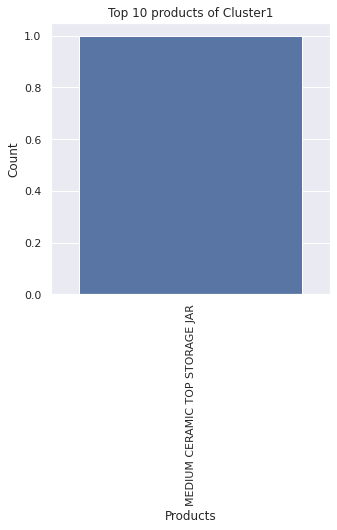

In [225]:
cluster1['Description'].value_counts()[:20]
RFM_score = cluster1['Description'].value_counts()[:10]
plt.figure(figsize=(5,5))
sns.barplot(RFM_score.index, RFM_score.values,order = RFM_score.index)
plt.ylabel("Count")
plt.xlabel('Products')
plt.title("Top 10 products of Cluster1");
plt.xticks(rotation=90);

In [226]:
custom_aggregation = {}
custom_aggregation["country"] = lambda x:x.iloc[0]
custom_aggregation["RFMScore"] = lambda x:x.iloc[0]

cluster1_grouped = cluster1.groupby("Customer_Id").agg(custom_aggregation)

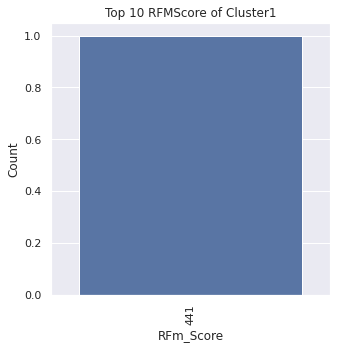

In [227]:
cluster1_grouped['RFMScore'].value_counts()
RFM_score = cluster1_grouped['RFMScore'].value_counts().iloc[:20]
plt.figure(figsize=(5,5))
sns.barplot(RFM_score.index, RFM_score.values,order = RFM_score.index)
plt.ylabel("Count")
plt.xlabel('RFm_Score')
plt.title("Top 10 RFMScore of Cluster1");
plt.xticks(rotation=90);

In [228]:
cluster1_grouped['country'].value_counts()

35    1
Name: country, dtype: int64